# EPİAŞ PTF/SMF — Ham Veriden Uçtan Uca: **EDA → Özellik Müh. → Model → HPO**
Bu defter, ham/işlenmiş dosyalardan başlayıp **temizlik → EDA → özellik üretimi → ölçekleme/encoding → modelleme → değerlendirme** adımlarını EPİAŞ PTF/SMF tahmini için uçtan uca gösterir.
- Baseline **Ridge**, **Hourwise Ridge (24 model)**, **Walk-forward** backtest
- Yardımcı sınıflandırma metrikleri (spike-flag)
- (Opsiyonel) **LightGBM/XGBoost** + **Optuna** ile zaman serisi CV HPO
- Çıktılar: `runs/<RUN_ID>/preds_*.parquet`, `report.parquet`, `manifest.json`, `features.txt`


In [1]:
# === Kullanıcı Parametreleri ===
TARGET = "ptf"                     # "ptf" veya "smf"
CUT = "2025-06-30 23:00:00+03:00"  # train/test ayrımı için kesim anı
RUN_ID = f"eda_{TARGET}_demo"

DATA_CANDIDATES = [
    "data/processed/fe_full_plus2_causal.parquet",
    "data/processed/fe_full_plus2.parquet",
    "data/processed/fe_full_plus.parquet",
    "data/processed/fe_full.parquet",
    "data/processed/fe_full.csv",
    "data/processed/fe_full_plus_winz.parquet",
    "data/processed/fe_full_std.parquet",
    "data/processed/features_ext.parquet",
    "data/processed/epias_features_full_fe_clean.csv",
    "data/processed/epias_features_full_fe.csv",
    "data/processed/epias_features_full_clean.csv",
    "data/processed/epias_features_full.csv",
    "data/processed/epias_features.csv",
]

TR_TZ = "Europe/Istanbul"

import os
os.makedirs("runs", exist_ok=True)
RUN_DIR = os.path.join("runs", RUN_ID)
os.makedirs(RUN_DIR, exist_ok=True)
print("RUN_DIR:", RUN_DIR)

RUN_DIR: runs\eda_ptf_demo


In [21]:
# === Importlar & Yardımcılar ===
import os, json, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)

def _read_any(path):
    if path.endswith(".parquet"):
        try:
            return pd.read_parquet(path)
        except Exception:
            try:
                return pd.read_parquet(path, engine="fastparquet")
            except Exception:
                import pyarrow.parquet as pq
                return pq.read_table(path, use_legacy_dataset=True).to_pandas()
    elif path.endswith(".csv"):
        return pd.read_csv(path)
    else:
        raise ValueError("Desteklenmeyen biçim: " + path)

def _first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

def _ensure_ts(df):
    if "timestamp" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "timestamp"})
        else:
            raise ValueError("Veride 'timestamp' yok (ve indeks tarih değil).")
    ts = pd.to_datetime(df["timestamp"], errors="coerce")
    if getattr(ts.dt, "tz", None) is None:
        ts = ts.dt.tz_localize(TR_TZ, nonexistent="shift_forward", ambiguous="NaT")
    else:
        ts = ts.dt.tz_convert(TR_TZ)
    df = df.copy()
    df["timestamp"] = ts
    return df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

def _safe_mape(y, yhat, min_y=10.0, eps=1e-6):
    y = np.asarray(y, dtype=float); yhat = np.asarray(yhat, dtype=float)
    denom = np.maximum(np.abs(y), min_y) + eps
    return float(np.mean(np.abs(yhat - y) / denom) * 100)

def _metrics_reg(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    rmse = float(np.sqrt(np.mean((yhat - y) ** 2)))
    mae  = float(np.mean(np.abs(yhat - y)))
    mape = _safe_mape(y, yhat)
    denom = np.sum((y - np.mean(y)) ** 2)
    r2   = float(1 - np.sum((yhat - y) ** 2) / (denom if denom > 1e-12 else 1e-12))
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2}

def _hourly_profile(df, target, pred_col):
    g = df.assign(hour=df["timestamp"].dt.hour)[["hour", target, pred_col]].groupby("hour", as_index=False)
    rows = []
    for h, d in g:
        m = _metrics_reg(d[target].values, d[pred_col].values)
        rows.append({"hour": h, **m})
    return pd.DataFrame(rows).sort_values("hour")

def plot_ts(df, cols, title):
    plt.figure()
    df = df.sort_values("timestamp")
    tail = df.tail(min(7*24, len(df)))
    for c in cols:
        plt.plot(tail["timestamp"], tail[c], label=c)
    plt.title(title)
    plt.xlabel("timestamp"); plt.ylabel("value")
    plt.legend(); plt.tight_layout(); plt.show()

In [23]:
# === Veri Yükle ===
DATA_PATH = _first_existing(DATA_CANDIDATES)
if DATA_PATH is None:
    raise SystemExit("Aday veri dosyalarından hiçbiri bulunamadı. DATA_CANDIDATES listesini güncelleyin.")
print("DATA_PATH:", DATA_PATH)

df_raw = _read_any(DATA_PATH)
df_raw = _ensure_ts(df_raw)
print("rows:", len(df_raw), "cols:", df_raw.shape[1])
df_raw.head()

DATA_PATH: data/processed/fe_full_plus2_causal.parquet
rows: 14783 cols: 56


,timestamp,ptf,smf,consumption_mwh,gen_total_mw,wind_share,solar_share,hydro_share,thermal_share,is_holiday,temperature_2m,relative_humidity_2m,wind_speed_10m,wind_gusts_10m,cloud_cover,shortwave_radiation,direct_radiation,diffuse_radiation,HDH,CDH,HDH_roll_24,CDH_roll_24,solar_cf_proxy,hour,dow,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,ptf_lag_1,ptf_lag_24,ptf_roll24_mean,smf_lag_1,smf_lag_24,smf_roll24_mean,consumption_mwh_lag_1,consumption_mwh_lag_24,consumption_mwh_roll24_mean,smf_roll24_std,smf_roll24_diff,smf_diff_1,smf_diff_24,consumption_lag_1,consumption_lag_24,consumption_roll24_mean,consumption_roll24_std,consumption_roll24_diff,consumption_diff_1,consumption_diff_24,ptf_roll24_std,ptf_roll24_diff,ptf_diff_1,ptf_diff_24
0,2024-01-03 00:00:00+03:00,2325.0,2389.0,34295.16,34238.71,0.064755,2.920671e-07,0.243592,0.691653,False,8.490,94.80,6.580,13.840,79.30,0.0,0.0,0.0,9.510,0.0,191.660,0.0,0.0,0,2,1,0.000000,1.000000,0.974928,-0.222521,0.5,0.866025,2198.0,1299.99,2060.299583,1698.0,560.0,1665.420417,36599.12,29663.42,36905.178750,845.549350,32.579583,-2.0,1598.0,36599.12,29663.42,36905.178750,6525.854464,-306.058750,-1834.41,4899.08,549.529096,137.700417,-100.01,1284.36
1,2024-01-03 01:00:00+03:00,2248.0,2248.0,32671.59,32614.62,0.064771,3.066110e-07,0.224995,0.710234,False,8.500,94.80,7.695,15.380,65.00,0.0,0.0,0.0,9.500,0.0,191.515,0.0,0.0,1,2,1,0.258819,0.965926,0.974928,-0.222521,0.5,0.866025,2325.0,1299.99,2103.008333,2389.0,500.0,1741.628750,34295.16,28162.30,37098.167917,823.728618,647.371250,691.0,1829.0,34295.16,28162.30,37098.167917,6368.984328,-2803.007917,-2303.96,4631.74,527.249218,221.991667,127.00,1025.01
2,2024-01-03 02:00:00+03:00,2188.0,2188.0,31302.90,31245.56,0.066595,3.200455e-07,0.220853,0.712552,False,8.160,94.30,7.430,15.185,63.85,0.0,0.0,0.0,9.840,0.0,191.505,0.0,0.0,2,2,1,0.500000,0.866025,0.974928,-0.222521,0.5,0.866025,2248.0,1285.81,2142.508750,2248.0,30.0,1814.462083,32671.59,27356.95,37286.055000,785.565996,433.537917,-141.0,1748.0,32671.59,27356.95,37286.055000,6156.893383,-4614.465000,-1623.57,4509.29,499.240611,105.491250,-77.00,948.01
3,2024-01-03 03:00:00+03:00,2188.0,2188.0,30497.60,30440.31,0.079567,3.285118e-07,0.203409,0.717024,False,7.570,94.75,6.245,14.470,51.85,0.0,0.0,0.0,10.430,0.0,191.750,0.0,0.0,3,2,1,0.707107,0.707107,0.974928,-0.222521,0.5,0.866025,2188.0,1299.98,2180.100000,2188.0,450.0,1904.378750,31302.90,26745.81,37450.469583,690.141950,283.621250,-60.0,2158.0,31302.90,26745.81,37450.469583,5928.673790,-6147.569583,-1368.69,3945.95,464.700445,7.900000,-60.00,902.19
4,2024-01-03 04:00:00+03:00,2098.0,2098.0,30392.33,30334.39,0.091064,3.296588e-07,0.192037,0.716899,False,7.365,92.95,7.415,13.295,39.25,0.0,0.0,0.0,10.635,0.0,193.080,0.0,0.0,4,2,1,0.866025,0.500000,0.974928,-0.222521,0.5,0.866025,2188.0,1285.82,2217.100833,2188.0,560.0,1976.795417,30497.60,26512.15,37606.794167,618.348757,211.204583,0.0,1738.0,30497.60,26512.15,37606.794167,5678.323155,-7109.194167,-805.30,3751.79,425.255079,-29.100833,0.00,888.02


## Veri Sözlüğü (EPİAŞ PTF/SMF EDA)

| Sütun | Tip/Aralık | Birim | Açıklama / Nasıl oluşturulur |
|---|---|---|---|
| **timestamp** | datetime (tz=Europe/Istanbul) | — | Gözlemin zaman damgası (saatlik). Zaman serisi analizi bu alana göre sıralanır. |
| **ptf** | float | TL/MWh | Piyasa Takas Fiyatı (hedef değişkenlerden biri). |
| **smf** | float | TL/MWh | Sistem Marjinal Fiyatı (diğer hedef). |
| **consumption_mwh** | float | MWh | Tüketim/çekiş miktarı (saatlik). |
| **gen_total_mw** | float | MW | Toplam üretim gücü (saatlik). |
| **wind_share** | float ∈ [0,1] | oran | Rüzgârın toplam üretimdeki payı. |
| **solar_share** | float ∈ [0,1] | oran | Güneşin toplam üretimdeki payı. |
| **hydro_share** | float ∈ [0,1] | oran | Hidrolik üretim payı. |
| **thermal_share** | float ∈ [0,1] | oran | Termik üretim payı. |
| **is_holiday** | {0,1} | — | Resmî tatil göstergesi (TR). 1=tatil, 0=değil. |
| **temperature_2m** | float | °C | 2 m hava sıcaklığı. |
| **relative_humidity_2m** | float | % | 2 m bağıl nem (0–100). |
| **wind_speed_10m** | float | m/s | 10 m rüzgâr hızı. |
| **wind_gusts_10m** | float | m/s | 10 m ani rüzgâr (gust). |
| **cloud_cover** | float | % | Bulutluluk (0–100). |
| **shortwave_radiation** | float | W/m² | Kısa dalga/radyasyon toplamı. |
| **direct_radiation** | float | W/m² | Doğrudan güneş radyasyonu. |
| **diffuse_radiation** | float | W/m² | Yayılı (diffuse) güneş radyasyonu. |
| **HDH** | float ≥ 0 | °C·saat | Heating Degree Hours:  \`HDH = max(0, T_base − temperature_2m)\`. Genelde T_base=18°C. |
| **CDH** | float ≥ 0 | °C·saat | Cooling Degree Hours:  \`CDH = max(0, temperature_2m − T_base)\`. Genelde T_base=22–24°C tercih edilir. |
| **HDH_roll_24** | float | °C·saat | Son 24 saatin (nedensel) **ortalama** veya **toplam** HDH’si. Çoğu kurulumda ortalama kullanılır; sizdeki üretime göre: önceki 24 saat üzerinden \`rolling mean\` (laglı) olarak hesaplanmıştır. |
| **CDH_roll_24** | float | °C·saat | Son 24 saatin (nedensel) CDH **ortalaması** (genelde). |
| **solar_cf_proxy** | float ∈ [0,1] | oran | Güneş kapasite faktörü vekili. Çoğunlukla radyasyon (örn. shortwave/direct) değerlerinin normalize edilmesiyle türetilir; “daha çok ışınım → daha yüksek değer”. |
| **hour** | int ∈ {0..23} | saat | Zaman damgasının saat bileşeni. |
| **dow** | int ∈ {0..6} | — | Haftanın günü (0=Mon … 6=Sun). |
| **month** | int ∈ {1..12} | — | Ay. |
| **hour_sin**, **hour_cos** | float ∈ [−1,1] | — | Saatin **döngüsel (cyclic)** kodlaması*.  \`sin(2π·hour/24)\`, \`cos(2π·hour/24)\`. |
| **dow_sin**, **dow_cos** | float ∈ [−1,1] | — | Günün **cyclic** kodlaması. \`sin(2π·dow/7)\`, \`cos(2π·dow/7)\`. |
| **month_sin**, **month_cos** | float ∈ [−1,1] | — | Ayın **cyclic** kodlaması. \`sin(2π·month/12)\`, \`cos(2π·month/12)\`. |
| **ptf_lag_1** | float | TL/MWh | PTF’in 1 saat gecikmeli değeri: \`ptf(t−1)\`. |
| **ptf_lag_24** | float | TL/MWh | PTF’in 24 saat gecikmeli değeri: \`ptf(t−24)\`. |
| **ptf_roll24_mean** | float | TL/MWh | PTF’in son 24 saatteki **nedensel ortalaması**: \`mean(ptf(t−1..t−24))\`. |
| **smf_lag_1** | float | TL/MWh | SMF’in 1 saat gecikmeli değeri. |
| **smf_lag_24** | float | TL/MWh | SMF’in 24 saat gecikmeli değeri. |
| **smf_roll24_mean** | float | TL/MWh | SMF’in son 24 saatteki **nedensel ortalaması**. |
| **consumption_mwh_lag_1** | float | MWh | Tüketimin 1 saat gecikmeli değeri. |
| **consumption_mwh_lag_24** | float | MWh | Tüketimin 24 saat gecikmeli değeri. |
| **consumption_mwh_roll24_mean** | float | MWh | Tüketimin son 24 saatteki **nedensel ortalaması**. |
| **smf_roll24_std** | float | TL/MWh | SMF’in son 24 saatteki nedensel **standart sapması**. |
| **smf_roll24_diff** | float | TL/MWh | **Not:** İki yaygın kullanım var: (A) \`smf(t−1) − smf(t−25)\` (24 saat aralıklı fark) **veya** (B) \`smf(t−1) − roll24_mean(t−1)\` (değer − 24 saatlik ortalama). Sizin setinizde büyük olasılıkla (A) ya da (B) kullanılmıştır (aşağıdaki “doğrulama” kodu ile 1 dk’da kontrol edebilirsiniz). |
| **smf_diff_1** | float | TL/MWh | \`smf(t−1) − smf(t−2)\`. |
| **smf_diff_24** | float | TL/MWh | \`smf(t−1) − smf(t−25)\` (gün-aşırı fark). |
| **consumption_lag_1** | float | MWh | (alternatif adlandırma) tüketim 1 saat gecikme. |
| **consumption_lag_24** | float | MWh | tüketim 24 saat gecikme. |
| **consumption_roll24_mean** | float | MWh | tüketimin son 24 saat **ortalaması** (nedensel). |
| **consumption_roll24_std** | float | MWh | tüketimin son 24 saat **std**’si (nedensel). |
| **consumption_roll24_diff** | float | MWh | **Not:** SMF’deki açıklama ile aynı; (A) \`cons(t−1) − cons(t−25)\` **veya** (B) \`cons(t−1) − roll24_mean(t−1)\`. |
| **consumption_diff_1** | float | MWh | \`cons(t−1) − cons(t−2)\`. |
| **consumption_diff_24** | float | MWh | \`cons(t−1) − cons(t−25)\`. |
| **ptf_roll24_std** | float | TL/MWh | PTF’in son 24 saat **std**’si (nedensel). |
| **ptf_roll24_diff** | float | TL/MWh | **Not:** (A) \`ptf(t−1) − ptf(t−25)\` **veya** (B) \`ptf(t−1) − roll24_mean(t−1)\`. |
| **ptf_diff_1** | float | TL/MWh | \`ptf(t−1) − ptf(t−2)\`. |
| **ptf_diff_24** | float | TL/MWh | \`ptf(t−1) − ptf(t−25)\`. |

>  **Döngüsel Kodlama**: Bu tür verileri makine öğrenmesi modellerinin daha iyi anlayabileceği hale getirmek için kullanılan bir yöntemdir. Basitçe, doğrusal bir sayı doğrusundaki döngüsel bir özelliği (örneğin 0'dan 23'e kadar olan saatler), bir daire üzerindeki koordinatlara dönüştürür. Bu dönüşüm için genellikle sinüs ve kosinüs fonksiyonları kullanılır.

> **“Nedensel (causal)” notu:** Tüm rolling/lag/diff hesapları **mevcut saat bilgisini kullanmaz**; sadece geçmiş (\`t−k\`) değerleriyle hesaplanır (ör. \`roll24_mean\` daima \`t−1..t−24\` penceresinden).

> **Gecikmeli (Lag), Yuvarlanan Ortalama (Roll_mean) ve Fark (Diff) Özellikleri Ne İşe Yarar?**
Veri biliminde bu üç özellik, özellikle zaman serisi analizlerinde ve tahmin modellerinde sıklıkla kullanılır. Bu özellikler, bir zaman serisindeki geçmiş verileri kullanarak gelecekteki değerleri tahmin etmeye yardımcı olur. Her biri, veriden farklı bir tür bilgi çıkarır.

>**Gecikmeli (Lag) Değerler**: Bir değişkenin belirli bir önceki zaman noktasındaki (bir önceki saat, bir önceki gün vb.) değerini ifade eder. Bir zaman serisindeki en güçlü tahmincilerden biri genellikle o serinin kendi geçmiş değerleridir. Örneğin, bugünün elektrik tüketimini tahmin etmek için dünün aynı saatteki tüketimini bilmek oldukça faydalıdır.

>**Yuvarlanan Ortalama (Rolling Mean) Değerleri**: Bir değişkenin belirli bir zaman aralığındaki (örneğin son 24 saat) ortalama değerini ifade eder. Veri setindeki gürültüyü (ani dalgalanmaları) azaltarak altta yatan temel trendi ortaya çıkarır. Modellerin daha stabil ve tutarlı tahminler yapmasına yardımcı olur. Örneğin, bir hisse senedinin 50 günlük hareketli ortalaması, o hissenin kısa vadeli dalgalanmalarından bağımsız olarak genel eğilimini gösterir.

>**Fark (Diff) Değerleri**: Bir değişkenin mevcut değeri ile belirli bir önceki zaman noktasındaki değeri arasındaki farkı gösterir. Veri setindeki mevsimsellik ve trend gibi yapısal özellikleri ortadan kaldırarak seriyi durağan (stationary) hale getirir. Bu, birçok istatistiksel ve makine öğrenmesi modelinin daha iyi performans göstermesini sağlar. Örneğin, bir önceki günün aynı saatiyle bugünün aynı saati arasındaki farkı almak, günlük döngüden bağımsız olarak değişimi yakalar. 

## 1) Genel Resim / Eksikler / Duplicates / Türler

In [41]:
display(df_raw.head(3)); display(df_raw.tail(3))
print("Şekil:", df_raw.shape)
display(df_raw.dtypes)

na = df_raw.isna().sum().sort_values(ascending=False)
display(na[na>0])

dupes = df_raw.duplicated(subset=["timestamp"]).sum()
print("timestamp bazlı duplicate sayısı:", dupes)

num_cols = [c for c in df_raw.columns if c not in ("timestamp",) and pd.api.types.is_numeric_dtype(df_raw[c])]
cat_cols = [c for c in df_raw.columns if c not in ("timestamp",) and not pd.api.types.is_numeric_dtype(df_raw[c])]
print("Sayısal:", len(num_cols), "Kategorik:", len(cat_cols))

,timestamp,ptf,smf,consumption_mwh,gen_total_mw,wind_share,solar_share,hydro_share,thermal_share,is_holiday,temperature_2m,relative_humidity_2m,wind_speed_10m,wind_gusts_10m,cloud_cover,shortwave_radiation,direct_radiation,diffuse_radiation,HDH,CDH,HDH_roll_24,CDH_roll_24,solar_cf_proxy,hour,dow,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,ptf_lag_1,ptf_lag_24,ptf_roll24_mean,smf_lag_1,smf_lag_24,smf_roll24_mean,consumption_mwh_lag_1,consumption_mwh_lag_24,consumption_mwh_roll24_mean,smf_roll24_std,smf_roll24_diff,smf_diff_1,smf_diff_24,consumption_lag_1,consumption_lag_24,consumption_roll24_mean,consumption_roll24_std,consumption_roll24_diff,consumption_diff_1,consumption_diff_24,ptf_roll24_std,ptf_roll24_diff,ptf_diff_1,ptf_diff_24
0,2024-01-03 00:00:00+03:00,2325.0,2389.0,34295.16,34238.71,0.064755,2.920671e-07,0.243592,0.691653,False,8.49,94.8,6.580,13.840,79.30,0.0,0.0,0.0,9.51,0.0,191.660,0.0,0.0,0,2,1,0.000000,1.000000,0.974928,-0.222521,0.5,0.866025,2198.0,1299.99,2060.299583,1698.0,560.0,1665.420417,36599.12,29663.42,36905.178750,845.549350,32.579583,-2.0,1598.0,36599.12,29663.42,36905.178750,6525.854464,-306.058750,-1834.41,4899.08,549.529096,137.700417,-100.01,1284.36
1,2024-01-03 01:00:00+03:00,2248.0,2248.0,32671.59,32614.62,0.064771,3.066110e-07,0.224995,0.710234,False,8.50,94.8,7.695,15.380,65.00,0.0,0.0,0.0,9.50,0.0,191.515,0.0,0.0,1,2,1,0.258819,0.965926,0.974928,-0.222521,0.5,0.866025,2325.0,1299.99,2103.008333,2389.0,500.0,1741.628750,34295.16,28162.30,37098.167917,823.728618,647.371250,691.0,1829.0,34295.16,28162.30,37098.167917,6368.984328,-2803.007917,-2303.96,4631.74,527.249218,221.991667,127.00,1025.01
2,2024-01-03 02:00:00+03:00,2188.0,2188.0,31302.90,31245.56,0.066595,3.200455e-07,0.220853,0.712552,False,8.16,94.3,7.430,15.185,63.85,0.0,0.0,0.0,9.84,0.0,191.505,0.0,0.0,2,2,1,0.500000,0.866025,0.974928,-0.222521,0.5,0.866025,2248.0,1285.81,2142.508750,2248.0,30.0,1814.462083,32671.59,27356.95,37286.055000,785.565996,433.537917,-141.0,1748.0,32671.59,27356.95,37286.055000,6156.893383,-4614.465000,-1623.57,4509.29,499.240611,105.491250,-77.00,948.01


,timestamp,ptf,smf,consumption_mwh,gen_total_mw,wind_share,solar_share,hydro_share,thermal_share,is_holiday,temperature_2m,relative_humidity_2m,wind_speed_10m,wind_gusts_10m,cloud_cover,shortwave_radiation,direct_radiation,diffuse_radiation,HDH,CDH,HDH_roll_24,CDH_roll_24,solar_cf_proxy,hour,dow,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,ptf_lag_1,ptf_lag_24,ptf_roll24_mean,smf_lag_1,smf_lag_24,smf_roll24_mean,consumption_mwh_lag_1,consumption_mwh_lag_24,consumption_mwh_roll24_mean,smf_roll24_std,smf_roll24_diff,smf_diff_1,smf_diff_24,consumption_lag_1,consumption_lag_24,consumption_roll24_mean,consumption_roll24_std,consumption_roll24_diff,consumption_diff_1,consumption_diff_24,ptf_roll24_std,ptf_roll24_diff,ptf_diff_1,ptf_diff_24
14780,2025-09-09 20:00:00+03:00,3074.01,2001.0,41320.69,38989.4,0.110459,2.564800e-07,0.135673,0.753867,False,21.115,69.4,5.445,10.985,9.1,0.0,0.0,0.0,0.0,0.0,0.0,32.19,0.0,20,1,9,-0.866025,0.500000,0.781831,0.62349,-1.0,-1.836970e-16,3074.01,3395.00,3107.144583,2001.0,3400.0,2133.250000,41320.69,46721.21,41806.817500,397.602407,-132.250000,0.0,-1394.0,41320.69,46721.21,41806.817500,1391.619577,-486.127500,0.0,-5688.70,93.786101,-33.134583,0.0,-320.99
14781,2025-09-09 21:00:00+03:00,3074.01,2001.0,41320.69,38989.4,0.110459,2.564800e-07,0.135673,0.753867,False,21.115,69.4,5.445,10.985,9.1,0.0,0.0,0.0,0.0,0.0,0.0,32.19,0.0,21,1,9,-0.707107,0.707107,0.781831,0.62349,-1.0,-1.836970e-16,3074.01,3392.27,3093.770000,2001.0,3400.0,2074.958333,41320.69,45294.56,41581.795833,292.463373,-73.958333,0.0,-1399.0,41320.69,45294.56,41581.795833,918.688772,-261.105833,0.0,-5400.52,71.093388,-19.760000,0.0,-320.99
14782,2025-09-09 22:00:00+03:00,3074.01,2001.0,41320.69,38989.4,0.110459,2.564800e-07,0.135673,0.753867,False,21.115,69.4,5.445,10.985,9.1,0.0,0.0,0.0,0.0,0.0,0.0,32.19,0.0,22,1,9,-0.500000,0.866025,0.781831,0.62349,-1.0,-1.836970e-16,3074.01,3229.99,3080.509167,2001.0,2377.0,2016.666667,41320.69,43613.36,41416.217917,76.750679,-15.666667,0.0,-1399.0,41320.69,43613.36,41416.217917,467.989304,-95.527917,0.0,-3973.87,31.839284,-6.499167,0.0,-318.26


Şekil: (14783, 56)


timestamp                      datetime64[ns, Europe/Istanbul]
ptf                                                    float64
smf                                                    float64
consumption_mwh                                        float64
gen_total_mw                                           float64
wind_share                                             float64
solar_share                                            float64
hydro_share                                            float64
thermal_share                                          float64
is_holiday                                                bool
temperature_2m                                         float64
relative_humidity_2m                                   float64
wind_speed_10m                                         float64
wind_gusts_10m                                         float64
cloud_cover                                            float64
shortwave_radiation                                    

Series([], dtype: int64)

timestamp bazlı duplicate sayısı: 0
Sayısal: 55 Kategorik: 0


## 2) Aykırı Değer: IQR & Robust Z-Score (özet)

In [49]:
import pandas as pd
import numpy as np

def iqr_bounds(s, q1=0.25, q3=0.75):
    # NaN değerleri temizle, float'a dönüştür ve NumPy dizisine çevir
    data = s.dropna().astype(float).values
    
    if len(data) == 0:
        return None, None
        
    ql, qu = np.quantile(data, q=[q1, q3])
    iqr = qu - ql
    return ql - 1.5 * iqr, qu + 1.5 * iqr

def robust_zscore(s):
    # NaN değerleri temizle, float'a dönüştür ve NumPy dizisine çevir
    data = s.dropna().astype(float).values
    
    if len(data) == 0:
        return pd.Series(dtype=float)

    med = np.median(data)
    mad = np.median(np.abs(data - med)) + 1e-9
    
    return (s - med) / (1.4826 * mad)

# Sütunları sayısal olup olmadıklarına göre filtrele
num_cols = [c for c in df_raw.columns if pd.api.types.is_numeric_dtype(df_raw[c])]
outlier_report = []

for c in num_cols[:30]:
    # IQR sınırlarını hesapla
    low, high = iqr_bounds(df_raw[c])
    
    # Eğer sınır değerleri dönmediyse döngüyü atla
    if low is None:
        outlier_report.append((c, 0, 0))
        continue
    
    # IQR aykırı değer sayısını hesapla
    # Bu satırda df_raw[c] serisi kullanıldığı için 'astype(float)' gerekli değil
    # çünkü low ve high değerleri zaten sayısal
    cnt_iqr = int(((df_raw[c] < low) | (df_raw[c] > high)).sum())
    
    # Robust z-skorunu hesapla
    z = robust_zscore(df_raw[c])
    
    # Robust z-skor aykırı değer sayısını hesapla
    cnt_z = int((np.abs(z) > 3.5).sum())
    
    outlier_report.append((c, cnt_iqr, cnt_z))

outlier_df = pd.DataFrame(outlier_report, columns=["col", "iqr_outliers", "robust_z>3.5"]).sort_values(
    ["iqr_outliers", "robust_z>3.5"], ascending=False
)

display(outlier_df.head(20))

,col,iqr_outliers,robust_z>3.5
18,CDH,2270,4878
15,direct_radiation,909,6711
0,ptf,624,349
7,thermal_share,137,4
11,wind_speed_10m,121,12
5,solar_share,118,6304
3,gen_total_mw,93,6
16,diffuse_radiation,67,5865
20,CDH_roll_24,42,7204
4,wind_share,25,0


In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def iqr_bounds_series(s, q1=0.25, q3=0.75):
    data = s.dropna().astype(float)
    if data.empty:
        return None, None
    ql, qu = data.quantile(q1), data.quantile(q3)
    iqr = qu - ql
    return ql - 1.5*iqr, qu + 1.5*iqr

def robust_z(s):
    data = s.dropna().astype(float)
    if data.empty:
        return pd.Series(index=s.index, dtype=float)
    med = np.median(data)
    mad = np.median(np.abs(data - med)) + 1e-9
    return (s - med) / (1.4826 * mad)

def plot_outliers(df, col, ts_col="timestamp", z_thresh=3.5):
    s = df[col].astype(float)
    low, high = iqr_bounds_series(s)
    z = robust_z(s)

    # bayraklar
    iqr_flag = (s < low) | (s > high) if low is not None else pd.Series(False, index=s.index)
    z_flag   = (np.abs(z) > z_thresh)

    fig = plt.figure(figsize=(10,8))

    # 1) Zaman serisi (son ~60 gün) + işaretler
    ax1 = fig.add_subplot(3,1,1)
    tail = df[[ts_col, col]].dropna().tail(24*60)
    ax1.plot(tail[ts_col], tail[col], label=col)
    # işaretle
    tail_idx = tail.index
    idx_iqr = tail_idx.intersection(s[iqr_flag].index)
    idx_z   = tail_idx.intersection(s[z_flag].index)
    ax1.scatter(df.loc[idx_iqr, ts_col], df.loc[idx_iqr, col], marker='o', s=10, label='IQR flag')
    ax1.scatter(df.loc[idx_z,   ts_col], df.loc[idx_z,   col], marker='x', s=10, label='Robust z flag')
    ax1.set_title(f"{col} — time series (last ~60 days)")
    ax1.legend()
    ax1.grid(True)

    # 2) Histogram
    ax2 = fig.add_subplot(3,1,2)
    ax2.hist(s.dropna().values, bins=60)
    ax2.set_title(f"{col} — histogram")
    ax2.grid(True)

    # 3) Boxplot (IQR)
    ax3 = fig.add_subplot(3,1,3)
    ax3.boxplot(s.dropna().values, vert=False, whis=1.5)
    ax3.set_title(f"{col} — boxplot (IQR whiskers)")
    ax3.grid(True)

    fig.tight_layout()
    plt.show()

def plot_outliers_multi(df, cols, ts_col="timestamp", z_thresh=3.5):
    for c in cols:
        try:
            plot_outliers(df, c, ts_col=ts_col, z_thresh=z_thresh)
        except Exception as e:
            print(f"Plot skipped for {c}: {e}")

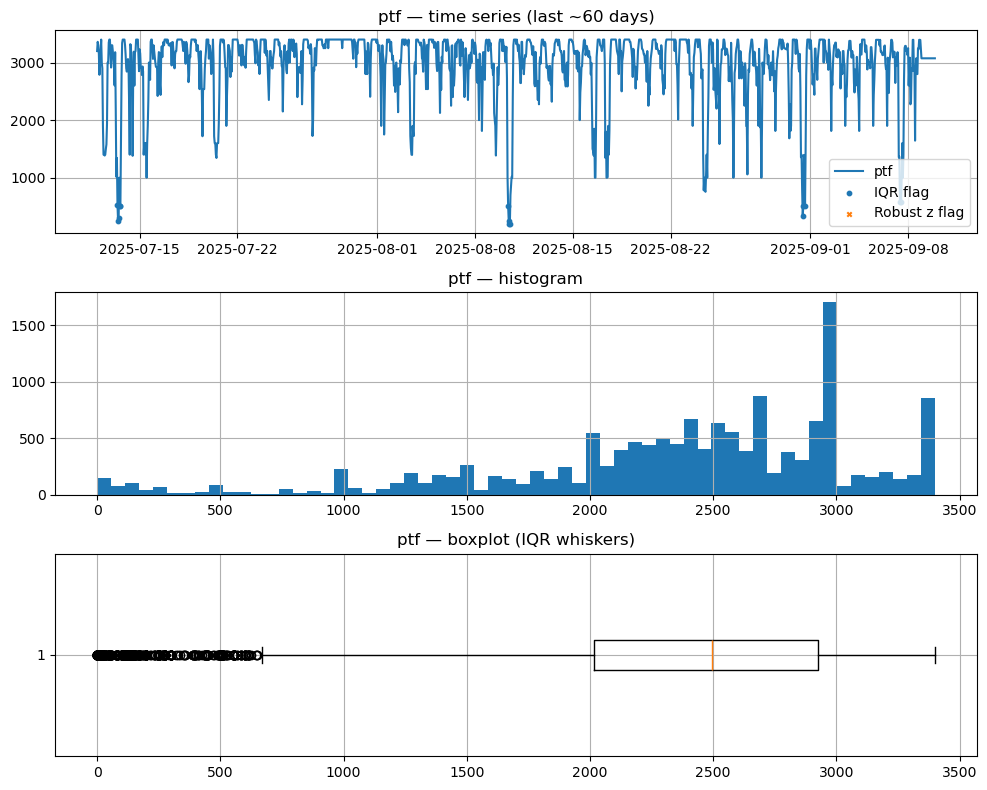

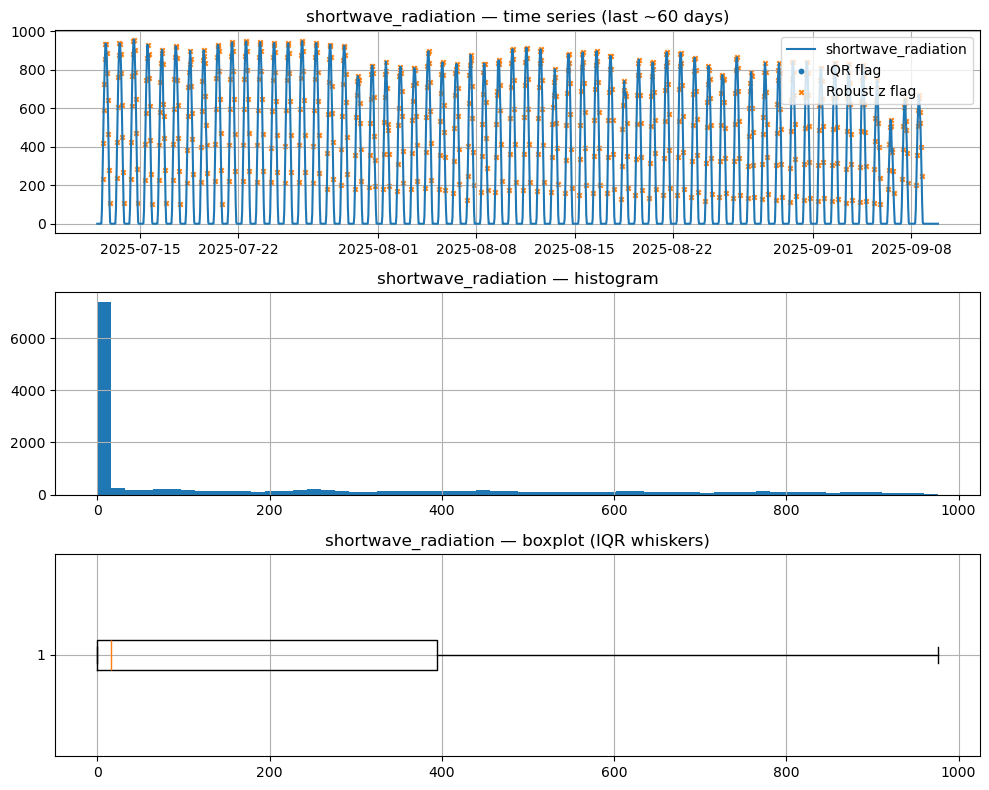

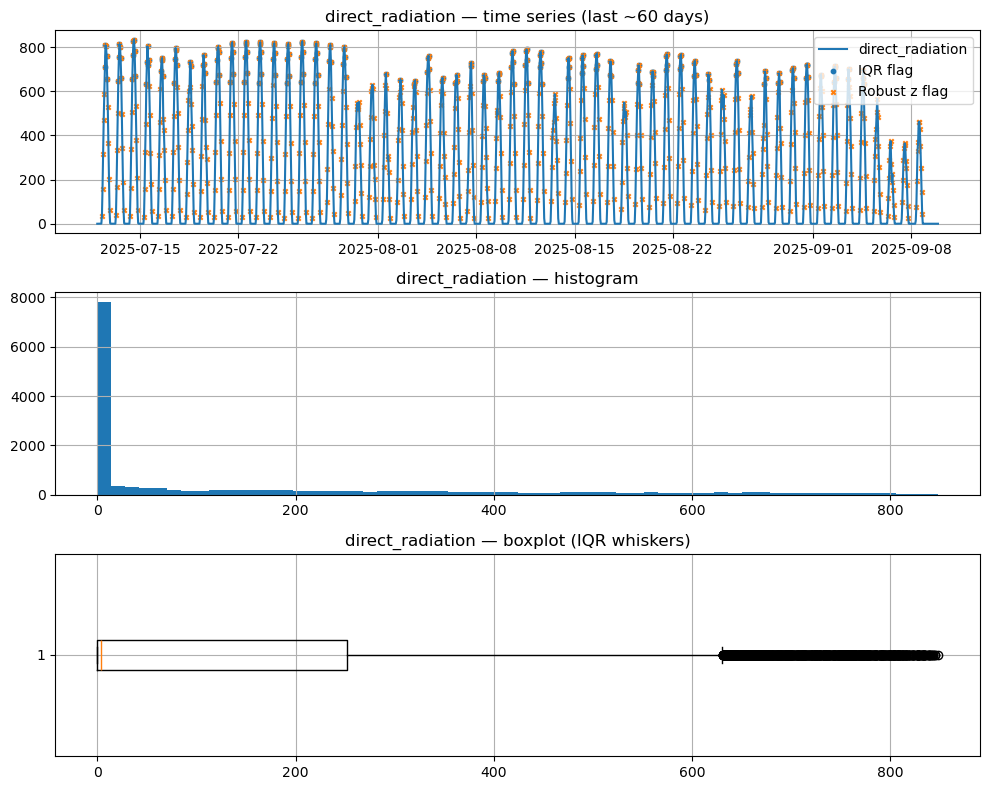

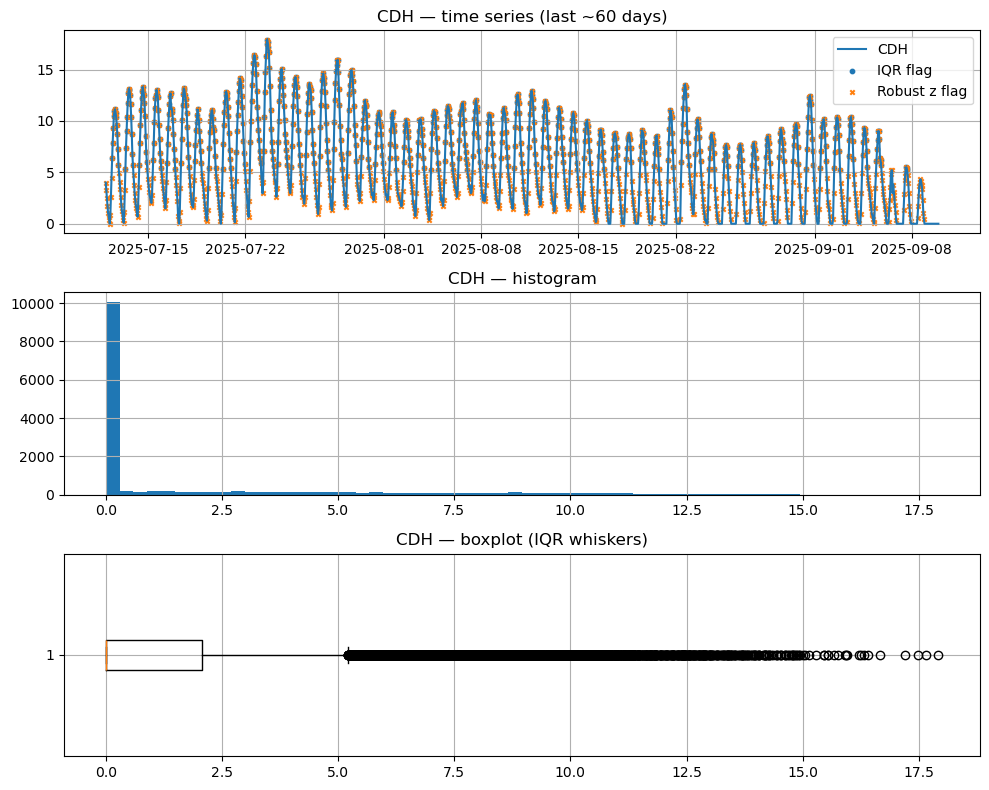

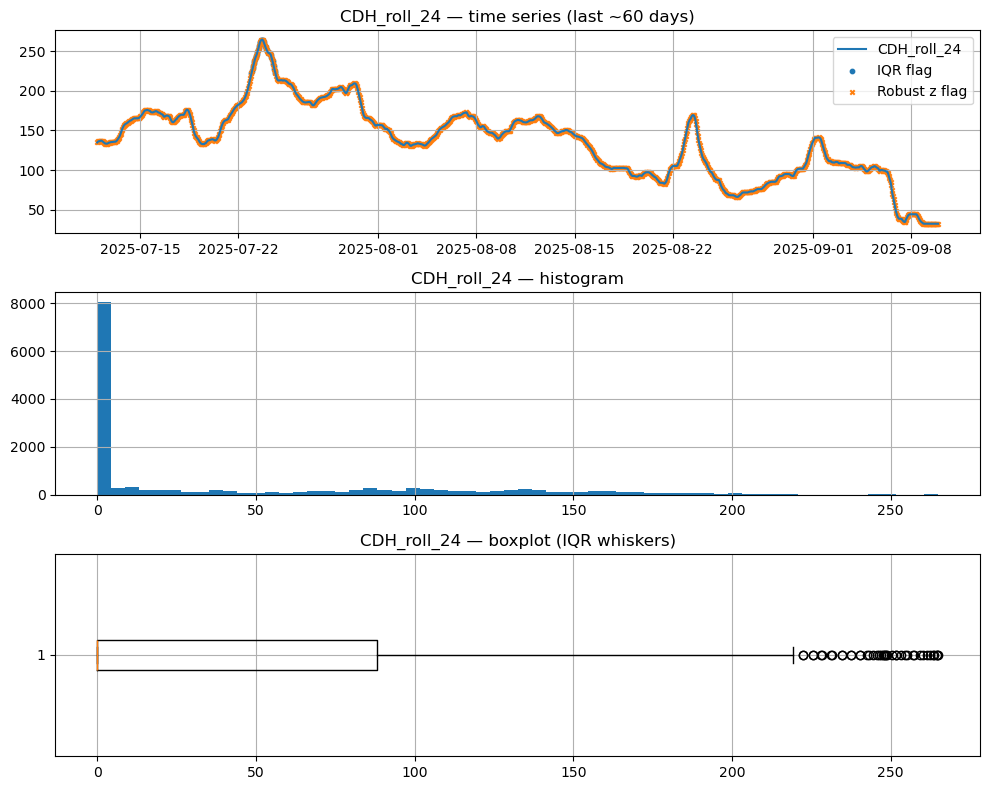

In [55]:
plot_outliers(df_raw, "ptf")
plot_outliers_multi(df_raw, ["shortwave_radiation","direct_radiation","CDH","CDH_roll_24"])

In [65]:
import numpy as np
import pandas as pd

def winsorize_by_hour(df, col, q_low=0.0025, q_high=0.9975):
    d = df.copy()
    d["_hour"] = d["timestamp"].dt.hour
    # her saat için ayrı eşik
    for h, idx in d.groupby("_hour").groups.items():
        s = d.loc[idx, col].astype(float)
        lo, hi = s.quantile(q_low), s.quantile(q_high)
        d.loc[idx, col] = s.clip(lo, hi)
    return d.drop(columns=["_hour"])

def global_winsorize(df, col, q_low=0.0025, q_high=0.9975):
    d = df.copy()
    s = d[col].astype(float)
    lo, hi = s.quantile(q_low), s.quantile(q_high)
    d[col] = s.clip(lo, hi)
    return d

def log1p_safe(df, col):
    d = df.copy()
    x = d[col].astype(float)
    # negatif olabilecek seriler için shift? fiyat>0 ise direkt log1p
    d[col+"_log1p"] = np.log1p(np.maximum(x, 0.0))
    return d

def clip_01(df, col):
    d = df.copy()
    d[col] = d[col].astype(float).clip(0.0, 1.0)
    return d

def clean_outliers(df):
    d = df.copy()

    # 1) Hedefler: fiyatlar (saat-bazlı winsorize, hafif)
    for tcol in [c for c in ["ptf","smf"] if c in d.columns]:
        d = winsorize_by_hour(d, tcol, q_low=0.0025, q_high=0.9975)

    # 2) Paylar: [0,1] fiziksel sınır
    for c in ["solar_share","wind_share","hydro_share","thermal_share"]:
        if c in d.columns:
            d = clip_01(d, c)

    # 3) Radyasyon & iklim türevleri: saat-bazlı winsorize (rejim farkı)
    for c in ["shortwave_radiation","direct_radiation","diffuse_radiation","CDH","HDH","CDH_roll_24","HDH_roll_24","solar_cf_proxy"]:
        if c in d.columns:
            d = winsorize_by_hour(d, c, q_low=0.0025, q_high=0.9975)
            # opsiyonel log1p:
            # d = log1p_safe(d, c)

    # 4) Rüzgâr hızları: global hafif winsorize (+opsiyonel log1p)
    for c in ["wind_speed_10m","wind_gusts_10m"]:
        if c in d.columns:
            d = global_winsorize(d, c, q_low=0.0025, q_high=0.9975)
            # d = log1p_safe(d, c)

    # 5) Genel üretim/tüketim: saat-bazlı winsorize
    for c in ["gen_total_mw","consumption_mwh"]:
        if c in d.columns:
            d = winsorize_by_hour(d, c, q_low=0.0025, q_high=0.9975)

    return d

# Uygulama:
df_clean = clean_outliers(df_raw)

In [77]:
clean_outliers(df_raw).head()

,timestamp,ptf,smf,consumption_mwh,gen_total_mw,wind_share,solar_share,hydro_share,thermal_share,is_holiday,temperature_2m,relative_humidity_2m,wind_speed_10m,wind_gusts_10m,cloud_cover,shortwave_radiation,direct_radiation,diffuse_radiation,HDH,CDH,HDH_roll_24,CDH_roll_24,solar_cf_proxy,hour,dow,month,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,ptf_lag_1,ptf_lag_24,ptf_roll24_mean,smf_lag_1,smf_lag_24,smf_roll24_mean,consumption_mwh_lag_1,consumption_mwh_lag_24,consumption_mwh_roll24_mean,smf_roll24_std,smf_roll24_diff,smf_diff_1,smf_diff_24,consumption_lag_1,consumption_lag_24,consumption_roll24_mean,consumption_roll24_std,consumption_roll24_diff,consumption_diff_1,consumption_diff_24,ptf_roll24_std,ptf_roll24_diff,ptf_diff_1,ptf_diff_24
0,2024-01-03 00:00:00+03:00,2325.0,2389.0,34295.16,34238.71,0.064755,2.920671e-07,0.243592,0.691653,False,8.490,94.80,6.580,13.840,79.30,0.0,0.0,0.0,9.510,0.0,191.660,0.0,0.0,0,2,1,0.000000,1.000000,0.974928,-0.222521,0.5,0.866025,2198.0,1299.99,2060.299583,1698.0,560.0,1665.420417,36599.12,29663.42,36905.178750,845.549350,32.579583,-2.0,1598.0,36599.12,29663.42,36905.178750,6525.854464,-306.058750,-1834.41,4899.08,549.529096,137.700417,-100.01,1284.36
1,2024-01-03 01:00:00+03:00,2248.0,2248.0,32671.59,32614.62,0.064771,3.066110e-07,0.224995,0.710234,False,8.500,94.80,7.695,15.380,65.00,0.0,0.0,0.0,9.500,0.0,191.515,0.0,0.0,1,2,1,0.258819,0.965926,0.974928,-0.222521,0.5,0.866025,2325.0,1299.99,2103.008333,2389.0,500.0,1741.628750,34295.16,28162.30,37098.167917,823.728618,647.371250,691.0,1829.0,34295.16,28162.30,37098.167917,6368.984328,-2803.007917,-2303.96,4631.74,527.249218,221.991667,127.00,1025.01
2,2024-01-03 02:00:00+03:00,2188.0,2188.0,31302.90,31245.56,0.066595,3.200455e-07,0.220853,0.712552,False,8.160,94.30,7.430,15.185,63.85,0.0,0.0,0.0,9.840,0.0,191.505,0.0,0.0,2,2,1,0.500000,0.866025,0.974928,-0.222521,0.5,0.866025,2248.0,1285.81,2142.508750,2248.0,30.0,1814.462083,32671.59,27356.95,37286.055000,785.565996,433.537917,-141.0,1748.0,32671.59,27356.95,37286.055000,6156.893383,-4614.465000,-1623.57,4509.29,499.240611,105.491250,-77.00,948.01
3,2024-01-03 03:00:00+03:00,2188.0,2188.0,30497.60,30440.31,0.079567,3.285118e-07,0.203409,0.717024,False,7.570,94.75,6.245,14.470,51.85,0.0,0.0,0.0,10.430,0.0,191.750,0.0,0.0,3,2,1,0.707107,0.707107,0.974928,-0.222521,0.5,0.866025,2188.0,1299.98,2180.100000,2188.0,450.0,1904.378750,31302.90,26745.81,37450.469583,690.141950,283.621250,-60.0,2158.0,31302.90,26745.81,37450.469583,5928.673790,-6147.569583,-1368.69,3945.95,464.700445,7.900000,-60.00,902.19
4,2024-01-03 04:00:00+03:00,2098.0,2098.0,30392.33,30334.39,0.091064,3.296588e-07,0.192037,0.716899,False,7.365,92.95,7.415,13.295,39.25,0.0,0.0,0.0,10.635,0.0,193.080,0.0,0.0,4,2,1,0.866025,0.500000,0.974928,-0.222521,0.5,0.866025,2188.0,1285.82,2217.100833,2188.0,560.0,1976.795417,30497.60,26512.15,37606.794167,618.348757,211.204583,0.0,1738.0,30497.60,26512.15,37606.794167,5678.323155,-7109.194167,-805.30,3751.79,425.255079,-29.100833,0.00,888.02


In [79]:
df_clean = clean_outliers(df_raw)

In [85]:
def changed_cols(df_before, df_after, cols=None, sample_n=5):
    cols = cols or list(set(df_before.columns) & set(df_after.columns))
    changed = {}
    for c in cols:
        b = df_before[c].astype(float)
        a = df_after[c].astype(float)
        # sadece iki taraf da sayısalsa karşılaştır
        try:
            mask = ~np.isclose(a, b, equal_nan=True)
        except Exception:
            continue
        if mask.any():
            changed[c] = int(mask.sum())
    if changed:
        print("Değişiklik görülen sütunlar (adet):", changed)
        # örnek göster
        c0 = max(changed, key=changed.get)
        diff_rows = (~np.isclose(df_after[c0], df_before[c0], equal_nan=True))
        display(pd.concat([df_before.loc[diff_rows, ["timestamp", c0]].rename(columns={c0: f"{c0}_before"}),
                           df_after.loc[diff_rows, [c0]].rename(columns={c0: f"{c0}_after"})], axis=1).head(sample_n))
    else:
        print("Hiçbir sütunda fark tespit edilmedi.")
        
changed_cols(df_raw, df_clean,
             cols=[c for c in ["ptf","smf","shortwave_radiation","direct_radiation","diffuse_radiation",
                               "CDH","HDH","CDH_roll_24","HDH_roll_24",
                               "solar_share","wind_share","hydro_share","thermal_share",
                               "gen_total_mw","consumption_mwh","wind_speed_10m","wind_gusts_10m"]
                   if c in df_raw.columns])

Değişiklik görülen sütunlar (adet): {'ptf': 48, 'smf': 18, 'shortwave_radiation': 48, 'direct_radiation': 44, 'diffuse_radiation': 50, 'CDH': 48, 'HDH': 48, 'CDH_roll_24': 48, 'HDH_roll_24': 48, 'gen_total_mw': 96, 'consumption_mwh': 96, 'wind_speed_10m': 74, 'wind_gusts_10m': 74}


,timestamp,gen_total_mw_before,gen_total_mw_after
2366,2024-04-10 14:00:00+03:00,14165.75,14407.969000
2367,2024-04-10 15:00:00+03:00,15303.28,15905.253125
2368,2024-04-10 16:00:00+03:00,17208.97,18186.871750
2369,2024-04-10 17:00:00+03:00,19913.76,21501.300625
2370,2024-04-10 18:00:00+03:00,22958.52,25077.065000


In [87]:
def q_minmax(df, col):
    s = df[col].astype(float)
    return {
        "min": float(s.min()), "max": float(s.max()),
        "q0.25%": float(s.quantile(0.0025)), "q99.75%": float(s.quantile(0.9975))
    }

for c in ["ptf","smf","shortwave_radiation","direct_radiation","diffuse_radiation",
          "CDH","HDH","CDH_roll_24","HDH_roll_24","gen_total_mw","consumption_mwh"]:
    if c in df_raw.columns:
        print(f"\n== {c} ==")
        print("raw :", q_minmax(df_raw, c))
        print("clean:", q_minmax(df_clean, c))


== ptf ==
raw : {'min': 0.0, 'max': 3400.0, 'q0.25%': 0.0, 'q99.75%': 3400.0}
clean: {'min': 0.0, 'max': 3400.0, 'q0.25%': 0.0, 'q99.75%': 3400.0}

== smf ==
raw : {'min': 0.0, 'max': 3400.0, 'q0.25%': 0.0, 'q99.75%': 3400.0}
clean: {'min': 0.0, 'max': 3400.0, 'q0.25%': 0.0, 'q99.75%': 3400.0}

== shortwave_radiation ==
raw : {'min': 0.0, 'max': 976.1, 'q0.25%': 0.0, 'q99.75%': 957.26125}
clean: {'min': 0.0, 'max': 972.775, 'q0.25%': 0.0, 'q99.75%': 957.26125}

== direct_radiation ==
raw : {'min': 0.0, 'max': 847.9499999999999, 'q0.25%': 0.0, 'q99.75%': 827.4545}
clean: {'min': 0.0, 'max': 844.6962500000001, 'q0.25%': 0.0, 'q99.75%': 827.4545}

== diffuse_radiation ==
raw : {'min': 0.0, 'max': 397.0, 'q0.25%': 0.0, 'q99.75%': 305.8130000000001}
clean: {'min': 0.0, 'max': 363.76937499999974, 'q0.25%': 0.0, 'q99.75%': 304.8427500000001}

== CDH ==
raw : {'min': 0.0, 'max': 17.92, 'q0.25%': 0.0, 'q99.75%': 14.543150000000004}
clean: {'min': 0.0, 'max': 16.165437499999992, 'q0.25%': 0.0, 

In [89]:
def outlier_counts(df, col, z_thresh=3.5):
    s = df[col].astype(float)
    # IQR
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_cnt = int(((s < low) | (s > high)).sum())
    # robust z
    med = np.median(s.dropna())
    mad = np.median(np.abs(s.dropna() - med)) + 1e-9
    z = (s - med) / (1.4826 * mad)
    z_cnt = int((np.abs(z) > z_thresh).sum())
    return iqr_cnt, z_cnt

cols_check = ["ptf","smf","shortwave_radiation","direct_radiation","diffuse_radiation",
              "CDH","CDH_roll_24","HDH","HDH_roll_24","gen_total_mw","consumption_mwh"]
rows = []
for c in cols_check:
    if c in df_raw.columns:
        iqr_b, z_b = outlier_counts(df_raw, c)
        iqr_a, z_a = outlier_counts(df_clean, c)
        rows.append([c, iqr_b, z_b, iqr_a, z_a])
        
pd.DataFrame(rows, columns=["col","IQR_before","Z>3.5_before","IQR_after","Z>3.5_after"])

,col,IQR_before,Z>3.5_before,IQR_after,Z>3.5_after
0,ptf,624,349,621,343
1,smf,0,699,0,699
2,shortwave_radiation,0,6327,0,6309
3,direct_radiation,909,6711,909,6704
4,diffuse_radiation,67,5865,67,5836
5,CDH,2270,4878,2268,4878
6,CDH_roll_24,42,7204,26,7204
7,HDH,20,3177,7,3177
8,HDH_roll_24,0,267,0,267
9,gen_total_mw,93,6,92,0


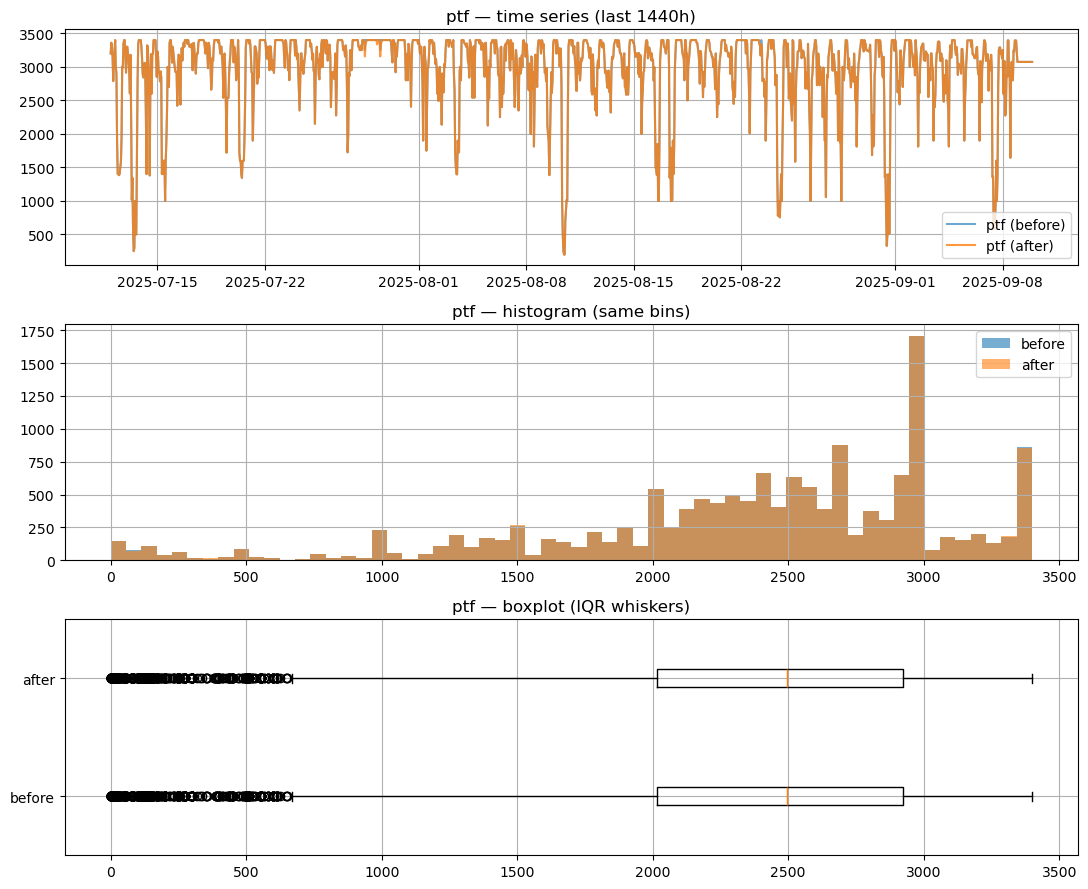

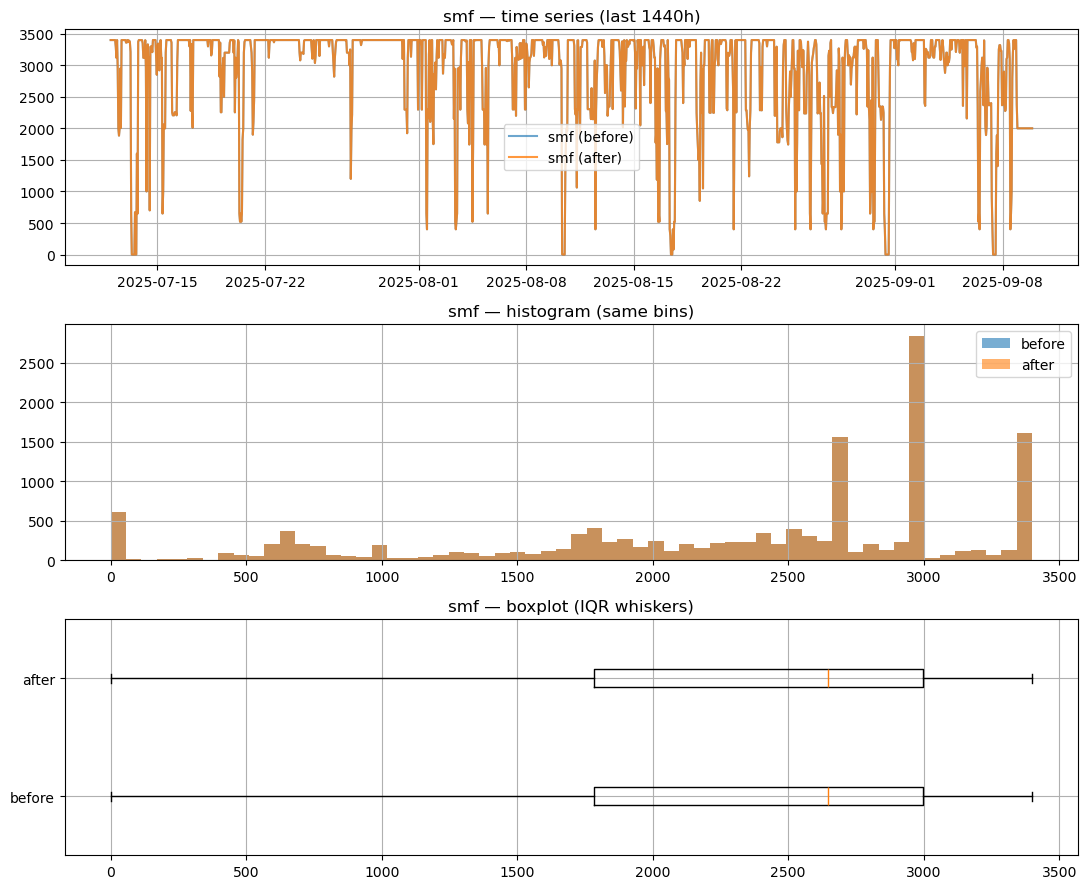

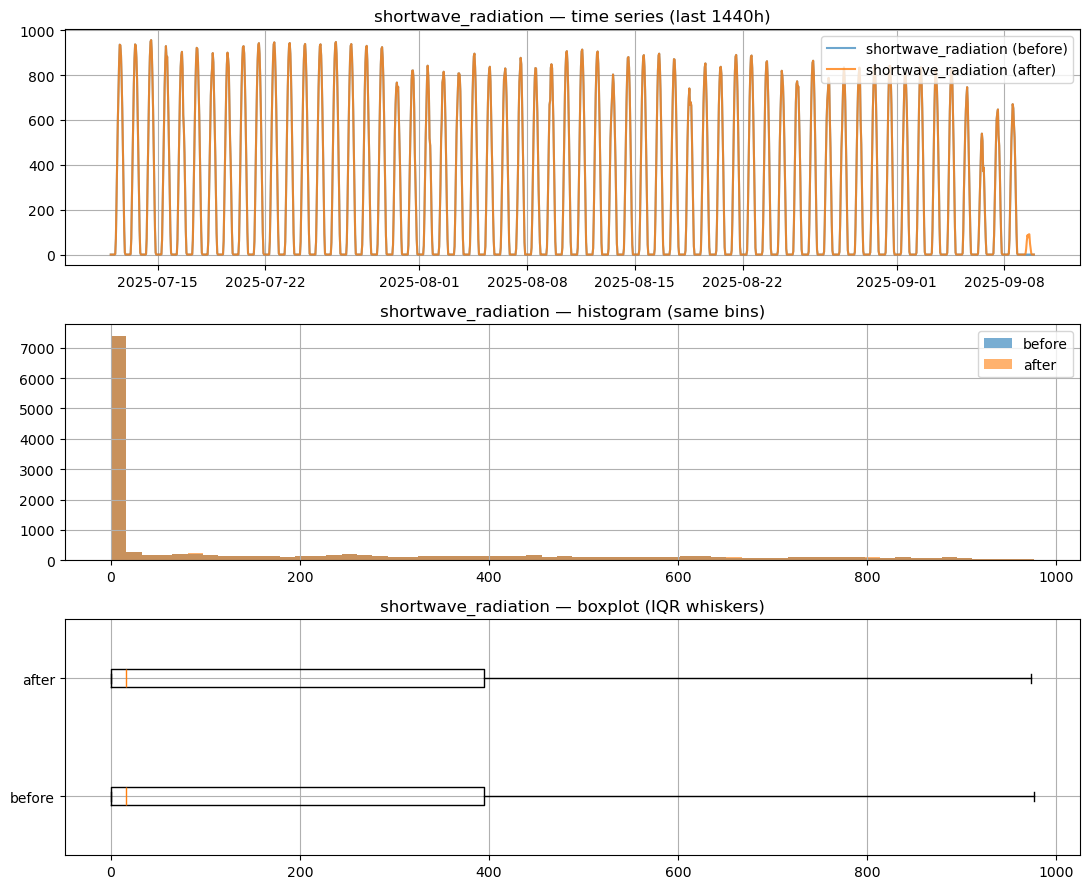

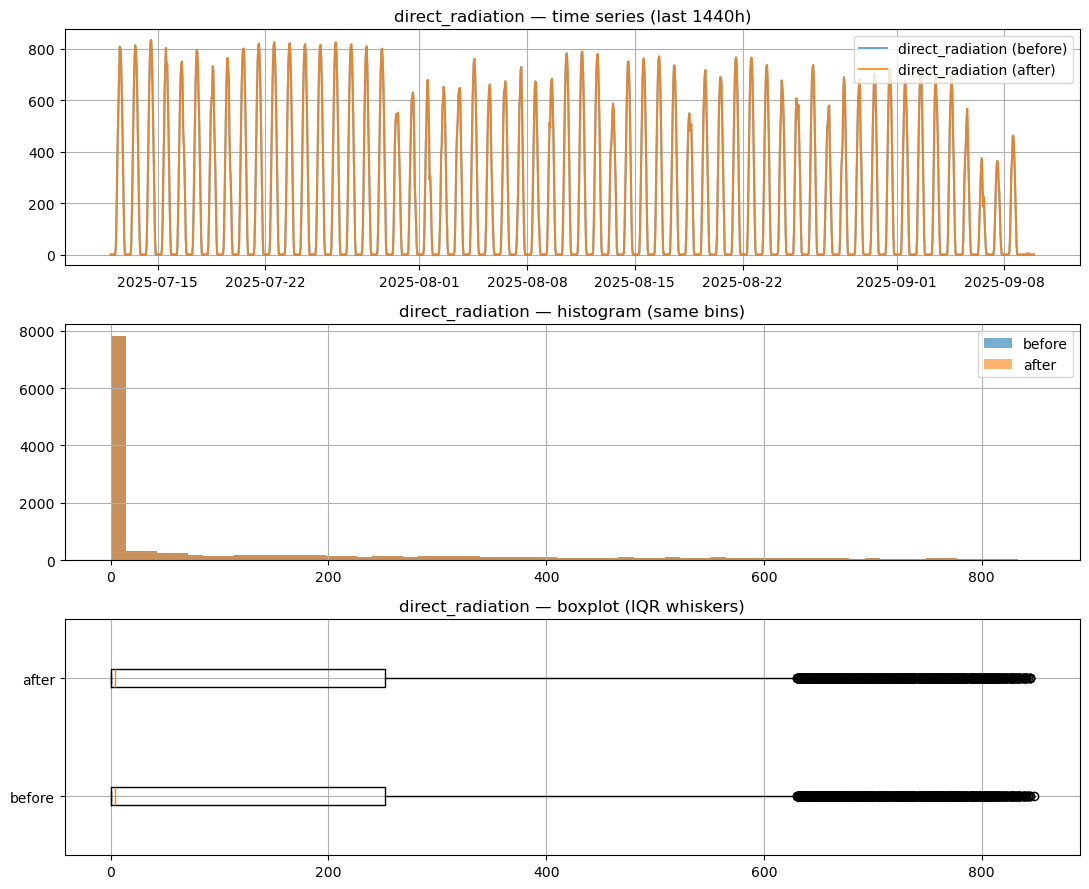

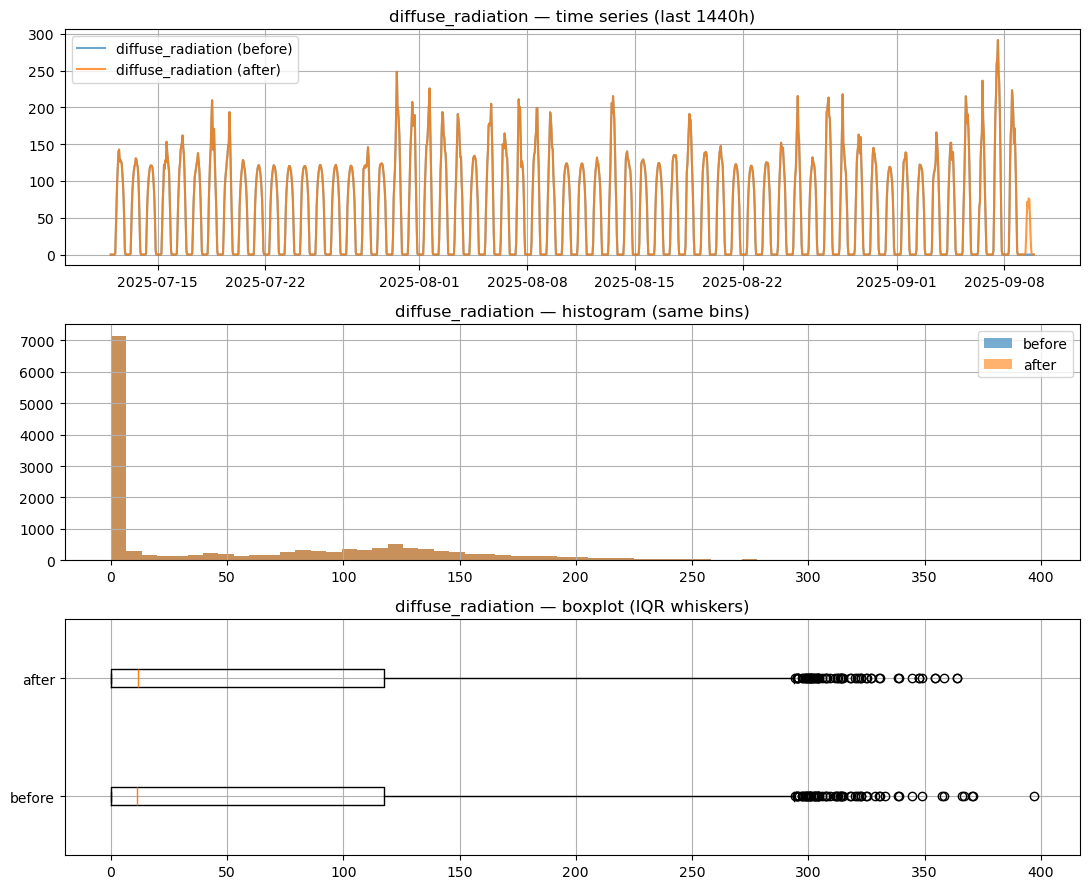

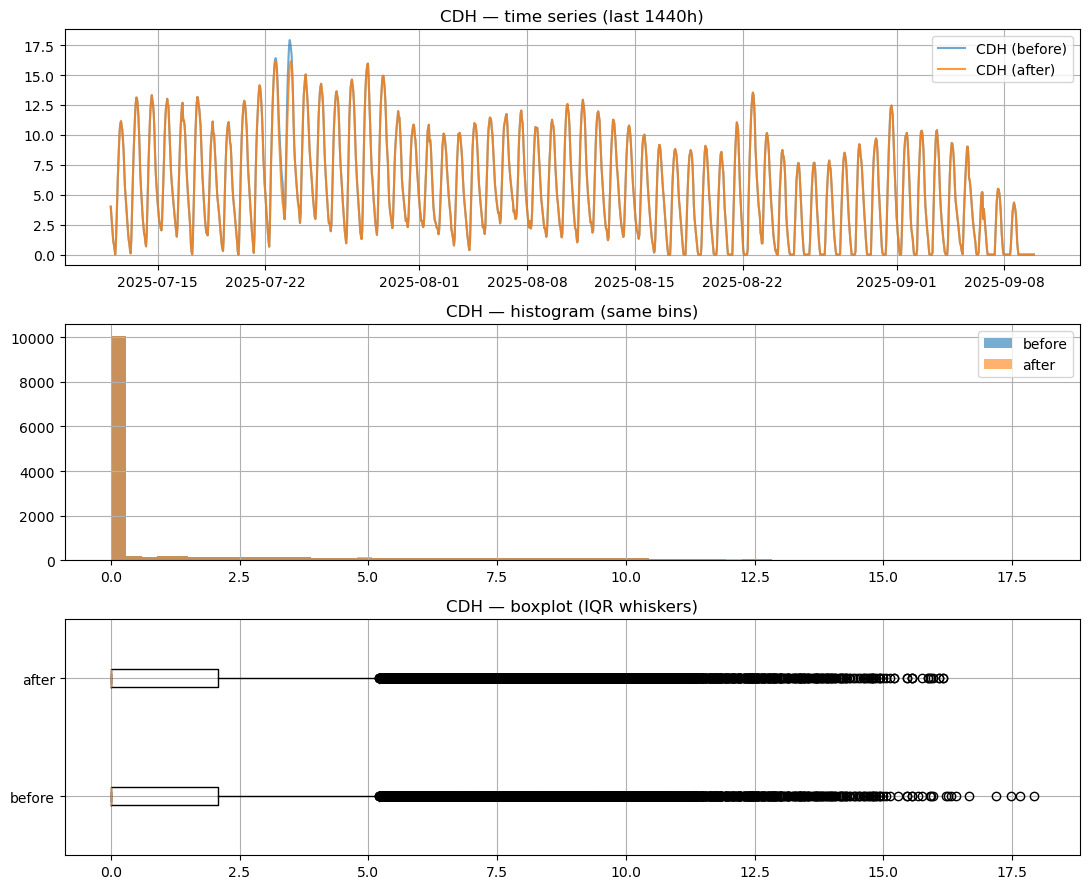

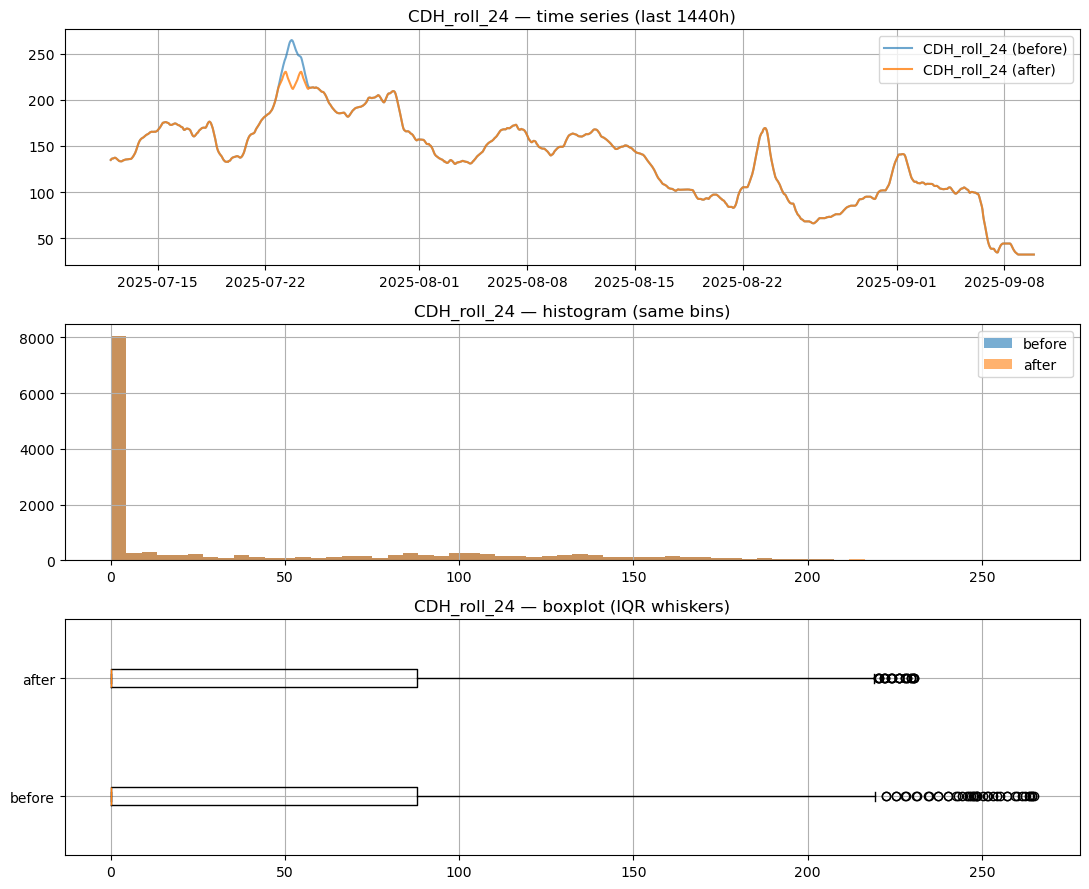

In [91]:
import matplotlib.pyplot as plt
import numpy as np

def plot_before_after(df_before, df_after, col, ts_col="timestamp", tail_hours=24*60):
    fig = plt.figure(figsize=(11,9))

    # 1) Zaman serisi (son N saat)
    ax1 = fig.add_subplot(3,1,1)
    tb = df_before[[ts_col, col]].dropna().tail(tail_hours)
    ta = df_after[[ts_col, col]].dropna().tail(tail_hours)
    ax1.plot(tb[ts_col], tb[col], label=f"{col} (before)", alpha=0.65)
    ax1.plot(ta[ts_col], ta[col], label=f"{col} (after)", alpha=0.8)
    ax1.set_title(f"{col} — time series (last {tail_hours}h)")
    ax1.legend(); ax1.grid(True)

    # 2) Histogram (aynı bin)
    ax2 = fig.add_subplot(3,1,2)
    data_b = df_before[col].dropna().astype(float).values
    data_a = df_after[col].dropna().astype(float).values
    bins = 60
    rng = (np.nanmin(np.concatenate([data_b, data_a])), np.nanmax(np.concatenate([data_b, data_a])))
    ax2.hist(data_b, bins=bins, range=rng, alpha=0.6, label="before")
    ax2.hist(data_a, bins=bins, range=rng, alpha=0.6, label="after")
    ax2.set_title(f"{col} — histogram (same bins)"); ax2.legend(); ax2.grid(True)

    # 3) Boxplot yan yana
    ax3 = fig.add_subplot(3,1,3)
    ax3.boxplot([data_b, data_a], vert=False, labels=["before","after"], whis=1.5)
    ax3.set_title(f"{col} — boxplot (IQR whiskers)")
    ax3.grid(True)

    fig.tight_layout()
    plt.show()

# örnek kullanımlar:
for c in ["ptf","smf","shortwave_radiation","direct_radiation","diffuse_radiation","CDH","CDH_roll_24"]:
    if c in df_raw.columns:
        plot_before_after(df_raw, df_clean, c)


## 3) Korelasyon (sayısal alt küme)

In [ ]:
subset = num_cols[:30] if len(num_cols) > 30 else num_cols
corr = df_raw[subset].corr(numeric_only=True)
plt.figure(figsize=(8,6)); plt.imshow(corr, interpolation="nearest"); plt.title("Correlation Matrix")
plt.colorbar(); plt.xticks(range(len(subset)), subset, rotation=90); plt.yticks(range(len(subset)), subset)
plt.tight_layout(); plt.show()
corr.iloc[:10,:10]

## 4) Temizlik (NA/duplicate)

In [ ]:
df = df_raw.drop_duplicates(subset=["timestamp"]).copy()

for c in num_cols:
    df[c] = df[c].astype(float).ffill().bfill().fillna(0.0)
for c in cat_cols:
    df[c] = df[c].ffill().bfill()

print("Temizlik sonrası şekil:", df.shape)

## 5) Özellik Mühendisliği (Causal, leakage yok)

In [ ]:
def add_calendar_feats(d):
    d = d.copy()
    d["hour"] = d["timestamp"].dt.hour.astype(int)
    d["dow"] = d["timestamp"].dt.dayofweek.astype(int)
    d["is_weekend"] = (d["dow"]>=5).astype(int)
    for col, period in [("hour",24), ("dow",7)]:
        rad = 2*np.pi*d[col]/period
        d[f"{col}_sin"] = np.sin(rad)
        d[f"{col}_cos"] = np.cos(rad)
    return d

def add_lags_rolls(d, col, lags=(1,24), roll=24):
    out = d.copy()
    if col not in out.columns: return out
    s = out[col]
    for L in lags:
        out[f"{col}_lag_{L}"] = s.shift(L)
    s_lag1 = s.shift(1)
    out[f"{col}_roll{roll}_mean"] = s_lag1.rolling(roll, min_periods=max(3, roll//3)).mean()
    out[f"{col}_roll{roll}_std"]  = s_lag1.rolling(roll, min_periods=max(3, roll//3)).std()
    out[f"{col}_diff_1"] = s.shift(1) - s.shift(2)
    if 24 in lags:
        out[f"{col}_diff_24"] = s.shift(1) - s.shift(25)
    return out

def add_ramps(d, cols):
    out = d.copy()
    for c in cols:
        if c in out.columns:
            out[f"{c}_ramp"] = out[c].shift(1) - out[c].shift(2)
    return out

def add_interactions(d):
    out = d.copy()
    def pref(c):
        return out.get(f"{c}_lag_1", out.get(c))
    pairs = [("cloud_cover","solar_share"),
             ("direct_radiation","solar_share"),
             ("shortwave_radiation","solar_share"),
             ("temperature_2m","wind_share")]
    for a,b in pairs:
        sa, sb = pref(a), pref(b)
        if sa is not None and sb is not None:
            out[f"{a}__x__{b}"] = sa * sb
    if "hour" in out.columns and pref("solar_share") is not None:
        out["hour__x__solar_share"] = out["hour"].astype(float) * pref("solar_share")
    return out

df_fe = add_calendar_feats(df)

for tgt in ["ptf","smf"]:
    if tgt in df_fe.columns:
        df_fe = add_lags_rolls(df_fe, tgt, lags=(1,24), roll=24)

share_cols = [c for c in ["solar_share","wind_share","hydro_share","thermal_share","gen_total","consumption","consumption_mwh","load","demand"] if c in df_fe.columns]
df_fe = add_ramps(df_fe, share_cols)
df_fe = add_interactions(df_fe)

drop_n = 48
df_fe = df_fe.iloc[drop_n:].reset_index(drop=True)
print("FE sonrası şekil:", df_fe.shape); df_fe.head(3)

## 6) Train/Test Ayrımı

In [ ]:
cut_ts = pd.to_datetime(CUT)
train = df_fe[df_fe["timestamp"] <= cut_ts].copy()
test  = df_fe[df_fe["timestamp"] >  cut_ts].copy()
print("Train/Test:", train.shape, test.shape)

assert TARGET in df_fe.columns, f"TARGET='{TARGET}' kolonu bulunamadı."

feat_cols = [c for c in df_fe.columns if c not in ["timestamp", TARGET] and pd.api.types.is_numeric_dtype(df_fe[c])]
print("Feature sayısı:", len(feat_cols))

## 7) Baseline Ridge (Scaler’lı Pipeline)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Xtr, ytr = train[feat_cols].fillna(0.0), train[TARGET].astype(float)
Xte, yte = test[feat_cols].fillna(0.0),  test[TARGET].astype(float)

pipe = Pipeline([("scaler", StandardScaler(with_mean=True, with_std=True)),
                 ("ridge", Ridge(alpha=10.0))])

pipe.fit(Xtr, ytr)
yhat = pipe.predict(Xte)
m = _metrics_reg(yte, yhat)
print("TEST metrics:", m)

preds = test[["timestamp", TARGET]].copy()
preds[f"{TARGET}_pred"] = yhat
preds.to_parquet(os.path.join(RUN_DIR, "preds_baseline.parquet"), index=False)

plot_ts(preds, [TARGET, f"{TARGET}_pred"], "Son 7 Gün — Gerçek vs Tahmin (Baseline)")
hp = _hourly_profile(preds, TARGET, f"{TARGET}_pred")
hp

## 8) Hourwise Ridge (24 ayrı model)

In [ ]:
from sklearn.base import clone
rows, parts = [], []
for h in range(24):
    tr_h = train[train["timestamp"].dt.hour == h]
    te_h = test[test["timestamp"].dt.hour == h]
    if tr_h.empty or te_h.empty: continue
    Xtr_h, ytr_h = tr_h[feat_cols].fillna(0.0), tr_h[TARGET].astype(float)
    Xte_h, yte_h = te_h[feat_cols].fillna(0.0), te_h[TARGET].astype(float)
    model_h = clone(pipe)
    model_h.fit(Xtr_h, ytr_h)
    yhat_h = model_h.predict(Xte_h)
    parts.append(pd.DataFrame({"timestamp": te_h["timestamp"], TARGET: yte_h, f"{TARGET}_pred": yhat_h, "hour": h}))
    rows.append({"hour": h, **_metrics_reg(yte_h, yhat_h)})
preds_h = pd.concat(parts, ignore_index=True).sort_values("timestamp")
preds_h.to_parquet(os.path.join(RUN_DIR, "preds_hourwise.parquet"), index=False)
hp = pd.DataFrame(rows).sort_values("hour"); hp

## 9) Walk-Forward Backtest (Ridge)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def walkforward(df_full, feat_cols, target, test_hours=168, folds=6, alpha=10.0):
    df_full = df_full.sort_values("timestamp").reset_index(drop=True)
    tail = test_hours * folds
    preds_all, fold_rows = [], []
    for k in range(1, folds+1):
        te = df_full.iloc[-(tail - test_hours*(k-1)) : -(tail - test_hours*k) if (tail - test_hours*k) > 0 else None]
        if te.empty: continue
        tr = df_full[df_full["timestamp"] < te["timestamp"].iloc[0]]
        if tr.empty: continue
        Xtr, ytr = tr[feat_cols].fillna(0.0), tr[target].astype(float)
        Xte, yte = te[feat_cols].fillna(0.0), te[target].astype(float)
        mdl = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=alpha))])
        mdl.fit(Xtr, ytr); yhat = mdl.predict(Xte)
        m = _metrics_reg(yte, yhat); m["fold"]=k
        pr = te[["timestamp", target]].copy(); pr[f"{target}_pred"]=yhat; pr["hour"]=pr["timestamp"].dt.hour; pr["fold"]=k
        preds_all.append(pr); fold_rows.append(m)
    preds = pd.concat(preds_all, ignore_index=True)
    fold_metrics = pd.DataFrame(fold_rows).sort_values("fold")
    overall = _metrics_reg(preds[target].values, preds[f"{target}_pred"].values)
    return preds, fold_metrics, overall

preds_wf, fold_m, overall_m = walkforward(df_fe, feat_cols, TARGET, test_hours=168, folds=6, alpha=10.0)
print("Overall WF:", overall_m)
preds_wf.to_parquet(os.path.join(RUN_DIR, "preds_walkforward.parquet"), index=False)
fold_m.head()

## 10) Yardımcı Sınıflandırma Metrikleri (Spike-Flag)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def spike_flag(s, q=0.9):
    thr = np.quantile(s, q)
    return (s >= thr).astype(int), thr

y_flag, thr_y = spike_flag(test[TARGET].values, q=0.9)
yhat_flag = (preds[f"{TARGET}_pred"].values >= thr_y).astype(int)

print("Spike eşiği:", thr_y)
print("Accuracy:", accuracy_score(y_flag, yhat_flag))
print("Precision:", precision_score(y_flag, yhat_flag, zero_division=0))
print("Recall:", recall_score(y_flag, yhat_flag, zero_division=0))
print("F1:", f1_score(y_flag, yhat_flag, zero_division=0))
print("Confusion Matrix:\n", confusion_matrix(y_flag, yhat_flag))

## 11) LightGBM/XGBoost + (Opsiyonel) Optuna HPO (Time-Series CV)

In [ ]:
USE_LIGHTGBM = True
USE_XGBOOST  = False

try:
    import optuna
    HAS_OPTUNA = True
except Exception:
    HAS_OPTUNA = False
    print("Optuna yok: pip install optuna (opsiyonel)")

def ts_cv_splits(ts, n_splits=3, test_hours=168):
    idx = np.arange(len(ts))
    folds = []
    for k in range(n_splits):
        te_start = len(ts) - (n_splits-k)*test_hours
        te_end   = te_start + test_hours
        tr_idx = idx[:te_start]; te_idx = idx[te_start:te_end]
        if len(tr_idx)==0 or len(te_idx)==0: continue
        folds.append((tr_idx, te_idx))
    return folds

X_all = df_fe[feat_cols].fillna(0.0).values
y_all = df_fe[TARGET].astype(float).values

def eval_model(mdl):
    preds = np.zeros_like(y_all)
    for tr_idx, te_idx in ts_cv_splits(df_fe["timestamp"].values, n_splits=3, test_hours=168):
        mdl_ = mdl
        mdl_.fit(X_all[tr_idx], y_all[tr_idx])
        preds[te_idx] = mdl_.predict(X_all[te_idx])
    return _metrics_reg(y_all, preds)

if USE_LIGHTGBM:
    try:
        from lightgbm import LGBMRegressor
        base = LGBMRegressor(random_state=42, n_estimators=500, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8)
        print("LGBM (base) 3-fold TS-CV:", eval_model(base))
        if HAS_OPTUNA:
            def objective(trial):
                params = dict(
                    num_leaves = trial.suggest_int("num_leaves", 15, 63),
                    max_depth = trial.suggest_int("max_depth", 4, 10),
                    min_child_samples = trial.suggest_int("min_child_samples", 20, 200),
                    subsample = trial.suggest_float("subsample", 0.6, 1.0),
                    colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0),
                    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 10.0),
                    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 10.0),
                    learning_rate = trial.suggest_float("learning_rate", 0.03, 0.2),
                    n_estimators = trial.suggest_int("n_estimators", 200, 1200),
                    random_state=42
                )
                model = LGBMRegressor(**params)
                m = eval_model(model)
                return m["RMSE"]
            study = optuna.create_study(direction="minimize")
            study.optimize(objective, n_trials=20, show_progress_bar=False)
            print("Optuna best params:", study.best_params)
    except Exception as e:
        print("LightGBM kullanılamadı:", e)

if USE_XGBOOST:
    try:
        from xgboost import XGBRegressor
        base = XGBRegressor(
            random_state=42, n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, max_depth=6, objective="reg:squarederror"
        )
        print("XGB (base) 3-fold TS-CV:", eval_model(base))
    except Exception as e:
        print("XGBoost kullanılamadı:", e)

## 12) Özellik Önemi / Katsayılar

In [ ]:
ridge = pipe.named_steps["ridge"]
coefs = pd.Series(ridge.coef_, index=feat_cols).sort_values(key=np.abs, ascending=False)
display(coefs.head(20))

plt.figure(figsize=(8,6))
topk = coefs.head(20)
plt.barh(topk.index[::-1], topk.values[::-1]); plt.title("Ridge | En etkili 20 özellik"); plt.tight_layout(); plt.show()

try:
    from lightgbm import LGBMRegressor
    model_lgbm = LGBMRegressor(random_state=42, n_estimators=400).fit(train[feat_cols], train[TARGET])
    imp = pd.Series(model_lgbm.feature_importances_, index=feat_cols).sort_values(ascending=False)[:20]
    plt.figure(figsize=(8,6))
    plt.barh(imp.index[::-1], imp.values[::-1]); plt.title("LightGBM | En önemli 20 özellik"); plt.tight_layout(); plt.show()
except Exception as e:
    print("LGBM importance atlanıyor:", e)

## 13) Raporları Kaydet

In [ ]:
overall = pd.DataFrame([_metrics_reg(preds[TARGET].values, preds[f"{TARGET}_pred"].values)])
hour_prof = _hourly_profile(preds, TARGET, f"{TARGET}_pred")
overall["table"]="overall"; hour_prof["table"]="hour_profile"
rep = pd.concat([overall, hour_prof], ignore_index=True)
rep.to_parquet(os.path.join(RUN_DIR, "report.parquet"), index=False)

with open(os.path.join(RUN_DIR, "manifest.json"), "w", encoding="utf-8") as f:
    json.dump({"TARGET":TARGET, "CUT":CUT, "RUN_ID":RUN_ID, "created":time.ctime(), "n_rows": len(df_fe), "n_features": len(feat_cols)}, f, ensure_ascii=False, indent=2)

with open(os.path.join(RUN_DIR, "features.txt"), "w", encoding="utf-8") as f:
    for c in feat_cols: f.write(c + "\n")

print("Kaydedilenler:", os.listdir(RUN_DIR))

### Notlar
- Karar metrikleri regresyonda **RMSE/MAE/R²**; **MAPE**’yi `min_y=10` korumalı hesaplıyoruz.
- Sınıflandırma metrikleri doğrudan regresyona uygulanmaz; bu yüzden **spike-flag** (üst %10) türetip Accuracy/F1/Recall hesapladık.
- Aşırı öğrenmeyi sınırlamak: Ridge düzenleme, **hourwise** modelleme ve **walk-forward** doğrulama. Ağaçlarda **erken durdurma/subsample** önerilir.
- HPO (Optuna) için 20 deneme başlangıçta yeterli; daha sonra kademeli artırılabilir.


In [ ]:

# === [SAFE HELPERS] ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

def _safe_mape(y, yhat, min_y=10.0, eps=1e-6):
    y = np.asarray(y, dtype=float); yhat = np.asarray(yhat, dtype=float)
    denom = np.maximum(np.abs(y), min_y) + eps
    return float(np.mean(np.abs(yhat - y) / denom) * 100)

def _metrics_reg(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    rmse = float(np.sqrt(np.mean((yhat - y) ** 2)))
    mae  = float(np.mean(np.abs(yhat - y)))
    mape = _safe_mape(y, yhat)
    denom = np.sum((y - np.mean(y)) ** 2)
    r2   = float(1 - np.sum((yhat - y) ** 2) / (denom if denom > 1e-12 else 1e-12))
    return {"RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2}

def ts_cv_splits(ts, n_splits=3, test_hours=168):
    idx = np.arange(len(ts))
    folds = []
    for k in range(n_splits):
        te_start = len(ts) - (n_splits-k)*test_hours
        te_end   = te_start + test_hours
        tr_idx = idx[:te_start]; te_idx = idx[te_start:te_end]
        if len(tr_idx)==0 or len(te_idx)==0: continue
        folds.append((tr_idx, te_idx))
    return folds


In [ ]:

# === [OUTLIER CLEANING] ===
def winsorize_by_hour(df, col, q_low=0.005, q_high=0.995):
    d = df.copy()
    d["_hour__tmp"] = d["timestamp"].dt.hour
    for h, idx in d.groupby("_hour__tmp").groups.items():
        s = d.loc[idx, col].astype(float)
        lo, hi = s.quantile(q_low), s.quantile(q_high)
        d.loc[idx, col] = s.clip(lo, hi)
    return d.drop(columns=["_hour__tmp"])

def global_winsorize(df, col, q_low=0.005, q_high=0.995):
    d = df.copy()
    s = d[col].astype(float)
    lo, hi = s.quantile(q_low), s.quantile(q_high)
    d[col] = s.clip(lo, hi)
    return d

def log1p_safe(df, col):
    d = df.copy()
    x = d[col].astype(float)
    d[col + "_log1p"] = np.log1p(np.maximum(x, 0.0))
    return d

def clip_01(df, col):
    d = df.copy()
    d[col] = d[col].astype(float).clip(0.0, 1.0)
    return d

def clean_outliers_param(df, q_low=0.01, q_high=0.99, do_log_radiation=True):
    d = df.copy()

    for tcol in [c for c in ["ptf","smf"] if c in d.columns]:
        d = winsorize_by_hour(d, tcol, q_low=q_low, q_high=q_high)

    for c in ["solar_share","wind_share","hydro_share","thermal_share"]:
        if c in d.columns:
            d = clip_01(d, c)

    for c in ["shortwave_radiation","direct_radiation","diffuse_radiation","CDH","HDH","CDH_roll_24","HDH_roll_24","solar_cf_proxy"]:
        if c in d.columns:
            d = winsorize_by_hour(d, c, q_low=q_low, q_high=q_high)
            if do_log_radiation:
                d = log1p_safe(d, c)

    for c in ["wind_speed_10m","wind_gusts_10m"]:
        if c in d.columns:
            d = global_winsorize(d, c, q_low=q_low, q_high=q_high)

    for c in ["gen_total_mw","consumption_mwh"]:
        if c in d.columns:
            d = winsorize_by_hour(d, c, q_low=q_low, q_high=q_high)

    return d

try:
    df_clean2 = clean_outliers_param(df_raw, q_low=0.01, q_high=0.99, do_log_radiation=True)
    print("df_clean2 ready:", df_clean2.shape)
except Exception as e:
    print("clean_outliers_param failed:", e)


In [ ]:

# === [DIAGNOSTICS] ===
def changed_cols(df_before, df_after, cols=None, sample_n=5):
    cols = cols or list(set(df_before.columns) & set(df_after.columns))
    changed = {}
    for c in cols:
        if c == "timestamp": continue
        b = pd.to_numeric(df_before[c], errors="coerce")
        a = pd.to_numeric(df_after[c], errors="coerce")
        try:
            mask = ~np.isclose(a, b, equal_nan=True)
        except Exception:
            continue
        if mask.any():
            changed[c] = int(mask.sum())
    if changed:
        print("Changed columns (count of changed rows):", changed)
        c0 = max(changed, key=changed.get)
        diff_rows = (~np.isclose(pd.to_numeric(df_after[c0], errors="coerce"),
                                 pd.to_numeric(df_before[c0], errors="coerce"), equal_nan=True))
        display(pd.concat([df_before.loc[diff_rows, ["timestamp", c0]].rename(columns={c0: f"{c0}_before"}),
                           df_after.loc[diff_rows, [c0]].rename(columns={c0: f"{c0}_after"})], axis=1).head(sample_n))
    else:
        print("No changes detected.")

def q_minmax(df, col, ql=0.0025, qh=0.9975):
    s = pd.to_numeric(df[col], errors="coerce")
    return {"min": float(s.min()), "max": float(s.max()),
            f"q{ql*100:.2f}%": float(s.quantile(ql)), f"q{qh*100:.2f}%": float(s.quantile(qh))}

def outlier_counts(df, col, z_thresh=3.5):
    s = pd.to_numeric(df[col], errors="coerce")
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_cnt = int(((s < low) | (s > high)).sum())
    med = np.nanmedian(s.values)
    mad = np.nanmedian(np.abs(s.values - med)) + 1e-9
    z = (s - med) / (1.4826 * mad)
    z_cnt = int((np.abs(z) > z_thresh).sum())
    return iqr_cnt, z_cnt

try:
    key_cols = [c for c in ["ptf","smf","shortwave_radiation","direct_radiation","diffuse_radiation",
                            "CDH","CDH_roll_24","HDH","HDH_roll_24","gen_total_mw","consumption_mwh"] if c in df_raw.columns]
    changed_cols(df_raw, df_clean2, cols=key_cols)
    rows = []
    for c in key_cols:
        rows.append([c, *outlier_counts(df_raw, c), *outlier_counts(df_clean2, c)])
    diag = pd.DataFrame(rows, columns=["col","IQR_b","Z_b","IQR_a","Z_a"])
    display(diag)
except Exception as e:
    print("Diagnostics failed:", e)


In [ ]:

# === [PLOTS] ===
def plot_before_after(df_before, df_after, col, ts_col="timestamp", tail_hours=24*60):
    fig = plt.figure(figsize=(11,9))

    ax1 = fig.add_subplot(3,1,1)
    tb = df_before[[ts_col, col]].dropna().tail(tail_hours)
    ta = df_after[[ts_col, col]].dropna().tail(tail_hours)
    ax1.plot(tb[ts_col], tb[col], label=f"{col} (before)", alpha=0.65)
    ax1.plot(ta[ts_col], ta[col], label=f"{col} (after)", alpha=0.8)
    ax1.set_title(f"{col} — time series (last {tail_hours}h)")
    ax1.legend(); ax1.grid(True)

    ax2 = fig.add_subplot(3,1,2)
    data_b = pd.to_numeric(df_before[col], errors="coerce").dropna().values
    data_a = pd.to_numeric(df_after[col], errors="coerce").dropna().values
    bins = 60
    rng = (np.nanmin(np.concatenate([data_b, data_a])), np.nanmax(np.concatenate([data_b, data_a])))
    ax2.hist(data_b, bins=bins, range=rng, alpha=0.6, label="before")
    ax2.hist(data_a, bins=bins, range=rng, alpha=0.6, label="after")
    ax2.set_title(f"{col} — histogram (same bins)"); ax2.legend(); ax2.grid(True)

    ax3 = fig.add_subplot(3,1,3)
    ax3.boxplot([data_b, data_a], vert=False, labels=["before","after"], whis=1.5)
    ax3.set_title(f"{col} — boxplot (IQR whiskers)")
    ax3.grid(True)

    fig.tight_layout()
    plt.show()

def hourly_boxplot(df, col):
    tmp = df.assign(hour=df["timestamp"].dt.hour)
    data = [pd.to_numeric(tmp.loc[tmp["hour"]==h, col], errors="coerce").dropna().values for h in range(24)]
    plt.figure(figsize=(12,5))
    plt.boxplot(data, positions=range(24), whis=1.5, showfliers=False)
    plt.title(f"{col} — hourly distribution (boxplot, no fliers)")
    plt.xlabel("hour"); plt.ylabel(col); plt.grid(True, axis="y")
    plt.show()

# Examples (comment/uncomment to plot):
# for c in ["ptf","smf","shortwave_radiation","direct_radiation"]:
#     if c in df_raw.columns:
#         plot_before_after(df_raw, df_clean2, c)
# hourly_boxplot(df_raw, "shortwave_radiation"); hourly_boxplot(df_clean2, "shortwave_radiation")


In [ ]:

# === [RIDGE ALPHA OPTIMIZATION | Global] ===
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

try:
    _df_for_model = df_fe if 'df_fe' in globals() else (df_clean2 if 'df_clean2' in globals() else df_raw)
    assert 'TARGET' in globals(), "Define TARGET (e.g., TARGET='ptf')"
    assert TARGET in _df_for_model.columns, f"TARGET '{TARGET}' not found in data."
    feat_cols = [c for c in _df_for_model.columns if c not in ["timestamp", TARGET] and pd.api.types.is_numeric_dtype(_df_for_model[c])]

    X_all = _df_for_model[feat_cols].fillna(0.0).values
    y_all = _df_for_model[TARGET].astype(float).values
    ts_all = _df_for_model["timestamp"].values

    def eval_alpha(alpha):
        preds = np.zeros_like(y_all, dtype=float)
        for tr_idx, te_idx in ts_cv_splits(ts_all, n_splits=3, test_hours=168):
            mdl = Pipeline([("scaler", StandardScaler()),
                            ("ridge", Ridge(alpha=float(alpha)))])
            mdl.fit(X_all[tr_idx], y_all[tr_idx])
            preds[te_idx] = mdl.predict(X_all[te_idx])
        return _metrics_reg(y_all, preds)

    alpha_grid = [2,5,8,12,20,40,60,120]
    rows = [{"alpha": a, **eval_alpha(a)} for a in alpha_grid]
    alpha_cv = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
    display(alpha_cv)
    best_alpha = float(alpha_cv.iloc[0]["alpha"])
    print("Best alpha (TS-CV, RMSE min):", best_alpha)
except Exception as e:
    print("Global alpha optimization failed:", e)


In [ ]:

# === [RIDGE ALPHA OPTIMIZATION | Hourwise] ===
from sklearn.base import clone

try:
    assert 'train' in globals() and 'test' in globals(), "Define train/test splits before hourwise search."
    alpha_grid = [2,5,8,12,20,40,60,120]
    pipe_tpl = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=10.0))])
    best_alpha_by_hour, rows, parts = {}, [], []
    for h in range(24):
        tr_h = train[train["timestamp"].dt.hour == h]
        te_h = test[test["timestamp"].dt.hour == h]
        if tr_h.empty or te_h.empty: continue

        tr_h = tr_h.sort_values("timestamp")
        if len(tr_h) > 168:
            valid_h = tr_h.iloc[-168:]
            fit_h   = tr_h.iloc[:-168]
        else:
            valid_h = tr_h.copy()
            fit_h   = tr_h.copy()

        Xfit, yfit = fit_h[feat_cols].fillna(0.0), fit_h[TARGET].astype(float)
        Xval, yval = valid_h[feat_cols].fillna(0.0), valid_h[TARGET].astype(float)
        Xte_h, yte_h = te_h[feat_cols].fillna(0.0), te_h[TARGET].astype(float)

        scores = []
        for a in alpha_grid:
            mdl = clone(pipe_tpl)
            mdl.set_params(ridge__alpha=float(a))
            mdl.fit(Xfit, yfit)
            yval_hat = mdl.predict(Xval)
            mval = _metrics_reg(yval, yval_hat)
            scores.append((a, mval["RMSE"]))
        scores = sorted(scores, key=lambda x: x[1])
        best_a = scores[0][0]
        best_alpha_by_hour[h] = float(best_a)

        mdl = clone(pipe_tpl)
        mdl.set_params(ridge__alpha=best_a)
        mdl.fit(tr_h[feat_cols].fillna(0.0), tr_h[TARGET].astype(float))
        yhat_h = mdl.predict(Xte_h)

        parts.append(pd.DataFrame({"timestamp": te_h["timestamp"], TARGET: yte_h, f"{TARGET}_pred": yhat_h, "hour": h}))
        rows.append({"hour": h, **_metrics_reg(yte_h, yhat_h)})

    preds_h = pd.concat(parts, ignore_index=True).sort_values("timestamp") if parts else pd.DataFrame()
    hp = pd.DataFrame(rows).sort_values("hour") if rows else pd.DataFrame()
    print("best_alpha_by_hour:", best_alpha_by_hour)
    display(hp.head(24))
except Exception as e:
    print("Hourwise alpha search failed:", e)


In [ ]:

# === [ROBUST BASELINE] HuberRegressor ===
from sklearn.linear_model import HuberRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

try:
    assert 'train' in globals() and 'test' in globals(), "Define train/test splits to run Huber baseline."
    Xtr = train[feat_cols].fillna(0.0)
    ytr = train[TARGET].astype(float)
    Xte = test[feat_cols].fillna(0.0)
    yte = test[TARGET].astype(float)

    huber = make_pipeline(StandardScaler(with_mean=True, with_std=True),
                          HuberRegressor(alpha=1e-4, epsilon=1.35))
    huber.fit(Xtr, ytr)
    yhat_h = huber.predict(Xte)
    print("Huber test metrics:", _metrics_reg(yte, yhat_h))
except Exception as e:
    print("Huber baseline failed:", e)
